In [440]:
import os.path

from src import params
from pathlib import Path
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import hdbscan
import ast
from collections import Counter

# read the fo+cancer data 
selected_cols = ['diseases_within_window_phecode','chapter_within_window_phecode']
data_file = "UKB_wave_0_diseases_first_occurrence_and_cancer.pkl"
df_phe_selected = pd.read_pickle(f'{str(params.final_data_path).replace("src/modelling/","")}/{data_file}')
type = 'fo+cancer'
df_cluster = ''
final_data_path = Path.cwd().parents[1]/'data/final_data'

hyp =  {'umap':{'pre_recruit': {'n_components': 3, 'n_neighbors': 20, 'min_dist': 0.2},
                '5_years': {'n_components': 3, 'n_neighbors': 50, 'min_dist': 0.1},
               '10_years': {'n_components': 3, 'n_neighbors': 20, 'min_dist': 0.2}}}

hyp['hdbscan']= {'pre_recruit': {'min_cluster_size': 25000, 'min_samples': 100,'disease_count_contrl':False},
               '5_years': {'min_cluster_size': 20000, 'min_samples': 150,'disease_count_contrl':False},
               '10_years': {'min_cluster_size': 20000, 'min_samples': 20,'disease_count_contrl':False}} # disease_count_contrl tbc 

df_phe_db = pd.read_csv(final_data_path.parents[1]/'Data/intermediate_files/all_icd_phecode.csv')
def get_phecode_description(phecode, df_phe_db,query_col='description'):
    phecode = phecode.replace('d_','')
    df_phe_db['phecode'] = df_phe_db['phecode'].astype(str)
    try:
        selected_value = df_phe_db.loc[df_phe_db['phecode']==str(phecode),query_col].values[0]
    except:
        selected_value=phecode
    return selected_value

def update_disease_counts(multi_condition_data, multi_cluster_disease_explore):
    """
    Function to calculate disease case counts and update the multi_cluster_disease_explore DataFrame.
    
    Parameters:
    multi_condition_data (DataFrame): The DataFrame containing multi-condition data.
    multi_cluster_disease_explore (DataFrame): The DataFrame containing disease exploration data to be updated.
    
    Returns:
    DataFrame: Updated multi_cluster_disease_explore DataFrame with calculated disease counts.
    """
    
    def get_case_counts(multi_condition_data, disease_code):
        """
        Helper function to calculate case counts based on the specified disease code.
        
        Parameters:
        multi_condition_data (DataFrame): The DataFrame containing multi-condition data.
        disease_code (str): The disease code to filter the data by.
        
        Returns:
        dict: A dictionary with case counts for different disease count categories.
        """
        # Get the counts of disease cases for each disease count
        temp = multi_condition_data.loc[multi_condition_data[disease_code] == 1, 'diseases_count'].value_counts().reset_index()
        temp.columns = ['diseases_count', 'count']

        # Initialize the case_counts dictionary with counts for case counts 1, 2, and 3
        case_counts = {case_count: temp.loc[temp['diseases_count'] == case_count, 'count'].sum() 
                       for case_count in [1, 2, 3]}

        # Handle the '3+' case separately
        case_counts['3+'] = temp.loc[temp['diseases_count'] > 3, 'count'].sum() if not temp[temp['diseases_count'] >= 3].empty else 0

        return case_counts

    # Loop through each disease in the multi_cluster_disease_explore DataFrame
    for disease in multi_cluster_disease_explore['disease']:
        case_counts = get_case_counts(multi_condition_data, disease)
        total_counts = multi_cluster_disease_explore.loc[multi_cluster_disease_explore['disease'] == disease, 'counts'].values[0]
        # Update the multi_cluster_disease_explore DataFrame with the calculated case counts
        multi_cluster_disease_explore.loc[multi_cluster_disease_explore['disease'] == disease, 'single_disease_count'] = case_counts[1]/total_counts
        multi_cluster_disease_explore.loc[multi_cluster_disease_explore['disease'] == disease, 'two_disease_count'] = case_counts[2]/total_counts
        multi_cluster_disease_explore.loc[multi_cluster_disease_explore['disease'] == disease, 'three_disease_count'] = case_counts[3]/total_counts
        multi_cluster_disease_explore.loc[multi_cluster_disease_explore['disease'] == disease, 'three_plus_disease_count'] = case_counts['3+']/total_counts
    
    return multi_cluster_disease_explore

## Pre-recruit

In [344]:
year_type = 'pre_recruit'

In [345]:
# select which years and mark chapters 
#file_path  = Path.cwd().parents[1]/f'result/hdbscan/umap_hdbscan_only_diseases_{type}_{year_type}_{hyp['umap'][year_type]['n_components']}_{hyp['umap'][year_type]['n_neighbors']}_euclidean_{hyp['umap'][year_type]['min_dist']}_{hyp['umap'][year_type]['min_cluster_size']}_{hyp['hdbscan'][year_type]['min_samples']}{"_no_diseases_count" if not disease_count_contrl else ""}.csv'

import os 
file_path = Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_{year_type}.pkl'

if not os.path.isfile(file_path):
    if type == 'fo+cancer':
        if year_type == '5_years':
            cols = ['phecode_pre_recruit','phecode_0_5']
            df_phe_selected['diseases_within_window_phecode'] = df_phe_selected[cols].apply(lambda x: list(set(x[0] + x[1])), axis=1)
        
        elif year_type == 'pre_recruit':
            cols = ['phecode_pre_recruit']
            df_phe_selected['diseases_within_window_phecode'] = df_phe_selected['phecode_pre_recruit']
            
        elif year_type == '10_years':
            cols = ['phecode_pre_recruit','phecode_0_5','phecode_5_10']
        
            df_phe_selected['diseases_within_window_phecode'] = df_phe_selected[cols].apply(lambda x: list(set(x[0] + x[1]+x[2])), axis=1)
            
        #  mark chapters 
        df_phe_db = pd.read_csv('/Users/valler/Python/OX_Thesis/Chapter_2_Disease_Clustering/Data/downloaded_data/ICD_10/phecode_definitions1.2.csv')
        df_phe_selected["chapter_within_window_phecode"] = [[df_phe_db.loc[df_phe_db['phecode']==disease,'category_number'].values[0] for disease in x] if str(x) not in params.nan_str else None for x in df_phe_selected["diseases_within_window_phecode"]]
        del df_phe_db
        
        for col in selected_cols:
            df_phe_selected[col] = [x if str(x)!='[]' else None for x in df_phe_selected[col]]
    elif type == 'HES':
        # or read the hospital data
        record_column = params.disease_record_column
        selected_cols = ['diseases_within_window_phecode_selected_chronic_first_occ','diseases_within_window_phecode_selected_category_chronic_first_occ']
        
        
        df_single_record = pd.read_csv(Path.cwd().parents[1]/f'data/intermediate_files/{record_column}_complete.csv')
        level = 'chronic'
        year_type = ''
        cols = [x for x in df_single_record.columns if 'phe' in x]
        # with gender and age? yes as they are part of the physical conditions
        df_phe_selected = df_single_record[['eid','21022','31']+selected_cols].copy()
        for column in selected_cols:
            df_phe_selected[column] = [ast.literal_eval(x) if str(x) not in params.nan_str else None for x in df_phe_selected[column]]
            
    # 2 add more columns to describe the diseases within the window
    nan_str = params.nan_str
    df_phe_selected['diseases_count'] = [len(x) if str(x) not in nan_str else 0 for x in df_phe_selected[selected_cols[0]]]
    
    
    # 0.3 flatten the selected_cols
    phe_unique = df_phe_selected[selected_cols[0]].explode().explode().dropna().unique().tolist()
    cat_unique = df_phe_selected[selected_cols[1]].explode().explode().dropna().unique().tolist()
    
    # phe code level
    df_phe_selected['phe_count'] = [Counter(x) if str(x) not in nan_str else None for x in df_phe_selected[selected_cols[0]]]
    df_phe_selected['cat_count'] = [Counter(x) if str(x) not in nan_str else None for x in df_phe_selected[selected_cols[1]]]
    
    # Create a new DataFrame for the new columns
    
    for columns,counter_colname,colname_sart in [[cat_unique,'cat_count','c_'],[phe_unique,'phe_count','d_']]:
        new_columns = {
            f'{colname_sart}{column}': [
                None if (str(x) == 'None') else x[column] if (column in x.keys()) else None
                for x in df_phe_selected[counter_colname]
            ]
            for column in columns  # Assuming target_columns is a list of columns you want to process
        }
        
        new_columns_df = pd.DataFrame(new_columns)
        df_phe_selected = pd.concat([df_phe_selected, new_columns_df], axis=1)
        
    
    
    #df_phe_selected.drop(columns=['diseases_within_window_phecode','chapter_within_window_phecode', 'phe_count'],inplace=True)
    df_phe_selected.fillna(0, inplace=True)
    
    # combine with the social data
    df = pd.read_pickle(final_data_path / 'UKB_wave_0_final_standardised.pkl')
    
    for col in ['21022','31']:
        if col not in df_phe_selected.columns.tolist():
            df_phe_selected = df_phe_selected.merge(df[['eid',col]],on='eid',how='left')
    
    # standardise the columns
    for column in ['21022','diseases_count']:
        df_phe_selected[column] = (df_phe_selected[column]-df_phe_selected[column].mean())/df_phe_selected[column].std()
    
    df = df.merge(df_phe_selected.drop(columns=['21022','31']), on='eid', how='left')

        
    # reading clustering results 
    n_components = hyp['umap'][year_type]['n_components']
    n_neighbors = hyp['umap'][year_type]['n_neighbors']
    min_dist = hyp['umap'][year_type]['min_dist']
    min_cluster_size = hyp['hdbscan'][year_type]['min_cluster_size']
    min_samples = hyp['hdbscan'][year_type]['min_samples']
    disease_count_contrl = hyp['hdbscan'][year_type]['disease_count_contrl']
    metric = 'euclidean'
    df_cluster_origin = pd.read_csv(Path.cwd().parents[1]/f'result/hdbscan/umap_hdbscan_only_diseases_{type}_{year_type}_{n_components}_{n_neighbors}_euclidean_{min_dist}_{min_cluster_size}_{min_samples}{"_no_diseases_count" if not disease_count_contrl else ""}.csv')
    df_cluster_origin.rename(columns={'cluster':f'cluster_{year_type}'},inplace=True)
    if isinstance(df_cluster,pd.DataFrame):
        df_cluster = pd.merge(df_cluster,df_cluster_origin[['eid',f'cluster_{year_type}']],on='eid',how='left')
    else:
        df_cluster = df_cluster_origin.copy()
    del df_cluster_origin
    
    df = df.merge(df_cluster,on='eid')
    df[selected_cols[0]]=df[selected_cols[0]].replace(0,None)
    df['diseases_count'] =  [len(x) if str(x) not in nan_str else 0 for x in df[selected_cols[0]]]
    
    df.to_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_{year_type}.pkl')
else:
    df=pd.read_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_{year_type}.pkl')

In [28]:
# codes to merge all the data together to do cross-timepoints analysis 

df_pre=pd.read_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_pre_recruit.pkl')
df_5_years = pd.read_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_5_years.pkl')
df_10_years = pd.read_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_10_years.pkl')

temp = pd.read_pickle(final_data_path / 'UKB_wave_0_final_standardised.pkl')
social_columns = set(temp.columns.tolist())-{'eid'}
df_pre.columns = [x if x in list(social_columns)+['eid'] else f'{x}_pre_recruit' if 'pre_recruit' not in x else x  for x in df_pre.columns]
df = pd.merge(df_10_years ,df_5_years[list(set(df_5_years.columns)-social_columns)],on='eid',suffixes=('_10_years','_5_years'))
df = pd.merge(df,df_pre[list(set(df_pre.columns)-social_columns)],on='eid')

del df_pre,df_5_years,df_10_years,temp

# multiple disease transition

In [346]:
year_type = 'pre_recruit'
multi_cluster_labels = {'pre_recruit':2,
                       '5_years':2,
                        '10_years':1}

df_analyse=pd.read_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_{year_type}.pkl')


# marking percentage of single diseases, 2 diseases and more than 2 conditions 
disease_columns = [x for x in df_analyse.columns if 'd_' in x] 
multi_condition_data = df_analyse[df_analyse[f'cluster_{year_type}'] == multi_cluster_labels[year_type]][disease_columns+['diseases_count']]

df_phe_db = pd.read_csv(final_data_path.parents[1]/'Data/intermediate_files/all_icd_phecode.csv')
multi_cluster_disease_explore = multi_condition_data[disease_columns].sum(axis=0).reset_index().rename(columns={'index':'disease',0:'counts'}).sort_values(by='counts',ascending=False)
multi_cluster_disease_explore['disease_name'] =  [get_phecode_description(x, df_phe_db) for  x in multi_cluster_disease_explore.disease]
multi_cluster_disease_explore['category'] = [get_phecode_description(x, df_phe_db,'category') for  x in multi_cluster_disease_explore.disease]
multi_cluster_disease_explore=update_disease_counts(multi_condition_data, multi_cluster_disease_explore)

In [265]:
selected_diseases = '401.1 495.0 476.0 296.2 564.1 340.0 411.3 721.0 562.1 411.8 351.0 455.0 716.2 600.0 250.2 835.0 622.1 411.2 280.1 618.1 610.8 274.1 172.2'.split(' ')  #TODO: this might need to be changed based on the prevalence of each time point
selected_diseases = [f'd_{x}' for x in selected_diseases]
# at least 10000 cases in the whole disease database (pre-recruit window)
# 122 types 

multi_cluster_disease_explore_selected = multi_cluster_disease_explore.loc[multi_cluster_disease_explore['disease'].isin(selected_diseases)].reset_index(drop=True)

In [266]:
# Check if any element in df_analyse['all_diseases'][0] is in selected_diseases 
df_analyse['all_diseases'] = df_analyse[disease_columns].apply(lambda row: [str(x) for x in disease_columns if x in selected_diseases], axis=1)
print(sum([any(disease in selected_diseases for disease in disease_row) for disease_row in df_analyse.loc[df_analyse[f'cluster_{year_type}']==multi_cluster_labels[year_type],'all_diseases']]),len(df_analyse.loc[df_analyse[f'cluster_{year_type}']==multi_cluster_labels[year_type],]))


351646 351646


In [267]:
# Filter the co-occurrence matrix to show only correlations above 0.5
multi_condition_data = df_analyse.loc[df_analyse[f'cluster_{year_type}'] == multi_cluster_labels[year_type],selected_diseases]
multi_condition_data.columns = [get_phecode_description(x,df_phe_db) for x in multi_condition_data.columns]
co_occurrence = multi_condition_data.corr()

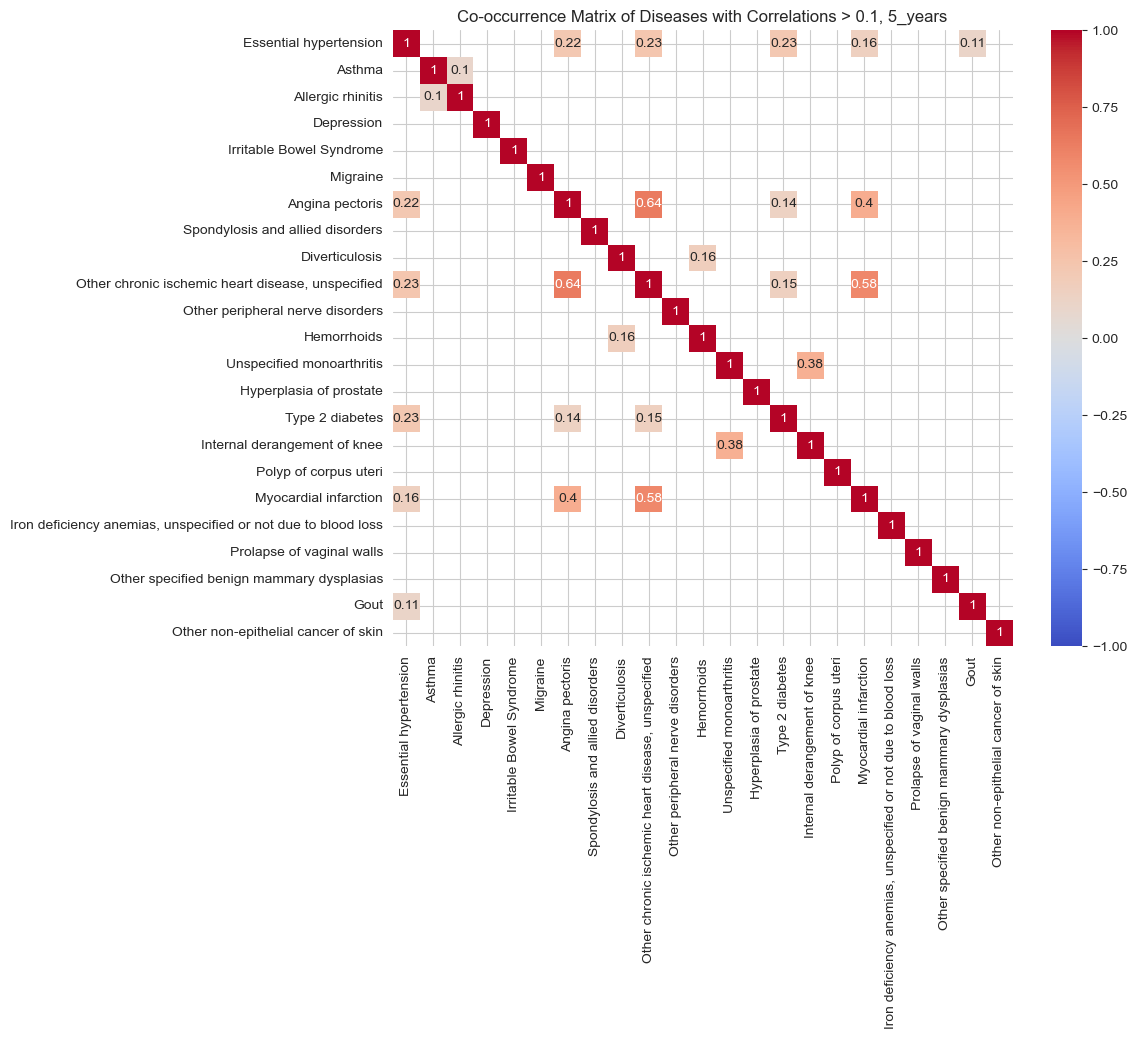

In [268]:
from matplotlib import pyplot as plt
import seaborn as sns 
# Plot the filtered co-occurrence matrix of strong correlations
plt.figure(figsize=(10, 8))

threshold=0.1
strong_correlations = co_occurrence[(co_occurrence > threshold)].dropna(axis=1, how='all').dropna(axis=0, how='all')
sns.heatmap(strong_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f'Co-occurrence Matrix of Diseases with Correlations > {threshold}, {year_type}')
plt.show()

In [269]:
# frequent itemset 

from mlxtend.frequent_patterns import apriori, association_rules

multi_condition_data = df_analyse[(df_analyse[f'cluster_{year_type}'] == multi_cluster_labels[year_type]) & (df_analyse['diseases_count']>1)]

disease_data = multi_condition_data.loc[multi_condition_data['diseases_count']>1,selected_diseases]
# Convert to 0/1 (binary) format
disease_data = disease_data.apply(lambda x: x.astype(bool))
disease_data.columns = [get_phecode_description(x,df_phe_db) for x in disease_data.columns]
# Apply the Apriori algorithm
frequent_itemsets = apriori(disease_data, min_support=0.01, use_colnames=True)

item_support = disease_data.mean()  # This gives the support of each individual item

# Add Lift to frequent itemsets
def calculate_lift(itemset, item_support, frequent_itemsets):
    """
    Calculate lift for a given itemset
    """
    # Get the support of the itemset
    itemset_support = frequent_itemsets.loc[frequent_itemsets['itemsets'] == itemset, 'support'].values[0]
    
    # Calculate the lift for the itemset
    lift = itemset_support / (item_support[list(itemset)].prod())
    return lift

# Apply the calculate_lift function to each itemset
frequent_itemsets['lift'] = frequent_itemsets['itemsets'].apply(lambda x: calculate_lift(x, item_support, frequent_itemsets))


In [270]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import itertools

# Apply threshold to support (e.g., support > 0.03)
threshold = 0.035
frequent_itemsets_filtered = frequent_itemsets[(frequent_itemsets['support'] > threshold) & (frequent_itemsets['lift'] > 1)]

# Create a graph for pairwise itemsets (2 items)
G_pairwise = nx.Graph()

# Separate dictionaries to store node positions for pairwise and multi-itemsets
pairwise_positions = {}
multi_itemsets = []

# Add edges based on the filtered itemsets
for idx, row in frequent_itemsets_filtered.iterrows():
    itemset = row['itemsets']
    support = row['support']
    lift = row['lift']
    
    # For pairwise itemsets (2 items), directly add the edges
    if len(itemset) == 2:
        disease1, disease2 = list(itemset)
        G_pairwise.add_edge(disease1, disease2, weight=support, lift=lift)
        pairwise_positions[disease1] = (support * 2, 0)
        pairwise_positions[disease2] = (support * 2, 1)
    
    # For multi-itemsets (3 or more items), store them for separate visualization
    elif len(itemset) > 2:
        multi_itemsets.append((itemset, support, lift))


In [271]:
import numpy as np 
pairwise_positions_fixed = {
 'Essential hypertension': np.array([0.2,  0.01896042]),
 'Angina pectoris': np.array([-0.3, 0.9]),
 'Hyperplasia of prostate': np.array([-0.5,  0.55]),
 'Diverticulosis': np.array([-0.5, -0.1]),
 'Other chronic ischemic heart disease, unspecified': np.array([ 0.17, 1.3]),
 'Unspecified monoarthritis': np.array([ -0.05, -1]),
 'Spondylosis and allied disorders': np.array([-0.4818918 , -0.92223966]),
 'Type 2 diabetes': np.array([0.9,  -0.6]),
 'Myocardial infarction': np.array([0.60531027, 0.96710847]),
 'Iron deficiency anemias, unspecified or not due to blood loss': np.array([0.81413377, 0.5]),
 'Gout': np.array([0.94548896, 0.03519587]),
 'Asthma': np.array([-0.8,  0.1846636 ]),
 'Depression': np.array([ -0.799, -0.8]),
 'Allergic rhinitis': np.array([-0.8,  1.1648251 ]),
 'Internal derangement of knee': np.array([0.41557554, -0.7        ])}

node_chapters = {get_phecode_description(x.replace('d_',''),df_phe_db):get_phecode_description(x.replace('d_',''),df_phe_db,query_col='category') for x in selected_diseases}

# Assign colors to each chapter dynamically using the colormap
unique_chapters = set(list(node_chapters.values()))
cmap = plt.get_cmap('Set3', lut=len(unique_chapters))  # Use the number of unique chapters
chapter_colors = {'neoplasms': (0.5529411764705883, 0.8274509803921568, 0.7803921568627451, 1.0), 'digestive': (1.0, 1.0, 0.7019607843137254, 1.0), 'respiratory': (0.7450980392156863, 0.7294117647058823, 0.8549019607843137, 1.0), 'hematopoietic': (0.984313725490196, 0.5019607843137255, 0.4470588235294118, 1.0), 'neurological': (0.5019607843137255, 0.6941176470588235, 0.8274509803921568, 1.0), 'endocrine/metabolic': (0.7019607843137254, 0.8705882352941177, 0.4117647058823529, 1.0), 'circulatory system': (0.9882352941176471, 0.803921568627451, 0.8980392156862745, 1.0), 'genitourinary': (0.8509803921568627, 0.8509803921568627, 0.8509803921568627, 1.0), 'injuries & poisonings': (0.7372549019607844, 0.5019607843137255, 0.7411764705882353, 1.0), 'mental disorders': (0.8, 0.9215686274509803, 0.7725490196078432, 1.0), 'musculoskeletal': (1.0, 0.9294117647058824, 0.43529411764705883, 1.0)}


In [112]:
new_keys=['congenital anomalies',
 'dermatologic',
 'infectious diseases',
 'pregnancy complications',
 'sense organs',
 'symptoms']
cmap = plt.get_cmap("tab20c", len(new_keys))  # "tab20c" colormap will provide distinct colors
new_colors = {key: cmap(i) for i, key in enumerate(new_keys)}

# Update the chapter_colors dictionary with the new colors
chapter_colors.update(new_colors)

# Verify the updated chapter_colors
print(chapter_colors)

{'neoplasms': (0.5529411764705883, 0.8274509803921568, 0.7803921568627451, 1.0), 'digestive': (1.0, 1.0, 0.7019607843137254, 1.0), 'respiratory': (0.7450980392156863, 0.7294117647058823, 0.8549019607843137, 1.0), 'hematopoietic': (0.984313725490196, 0.5019607843137255, 0.4470588235294118, 1.0), 'neurological': (0.5019607843137255, 0.6941176470588235, 0.8274509803921568, 1.0), 'endocrine/metabolic': (0.7019607843137254, 0.8705882352941177, 0.4117647058823529, 1.0), 'circulatory system': (0.9882352941176471, 0.803921568627451, 0.8980392156862745, 1.0), 'genitourinary': (0.8509803921568627, 0.8509803921568627, 0.8509803921568627, 1.0), 'injuries & poisonings': (0.7372549019607844, 0.5019607843137255, 0.7411764705882353, 1.0), 'mental disorders': (0.8, 0.9215686274509803, 0.7725490196078432, 1.0), 'musculoskeletal': (1.0, 0.9294117647058824, 0.43529411764705883, 1.0), 'congenital anomalies': (0.19215686274509805, 0.5098039215686274, 0.7411764705882353, 1.0), 'dermatologic': (0.901960784313

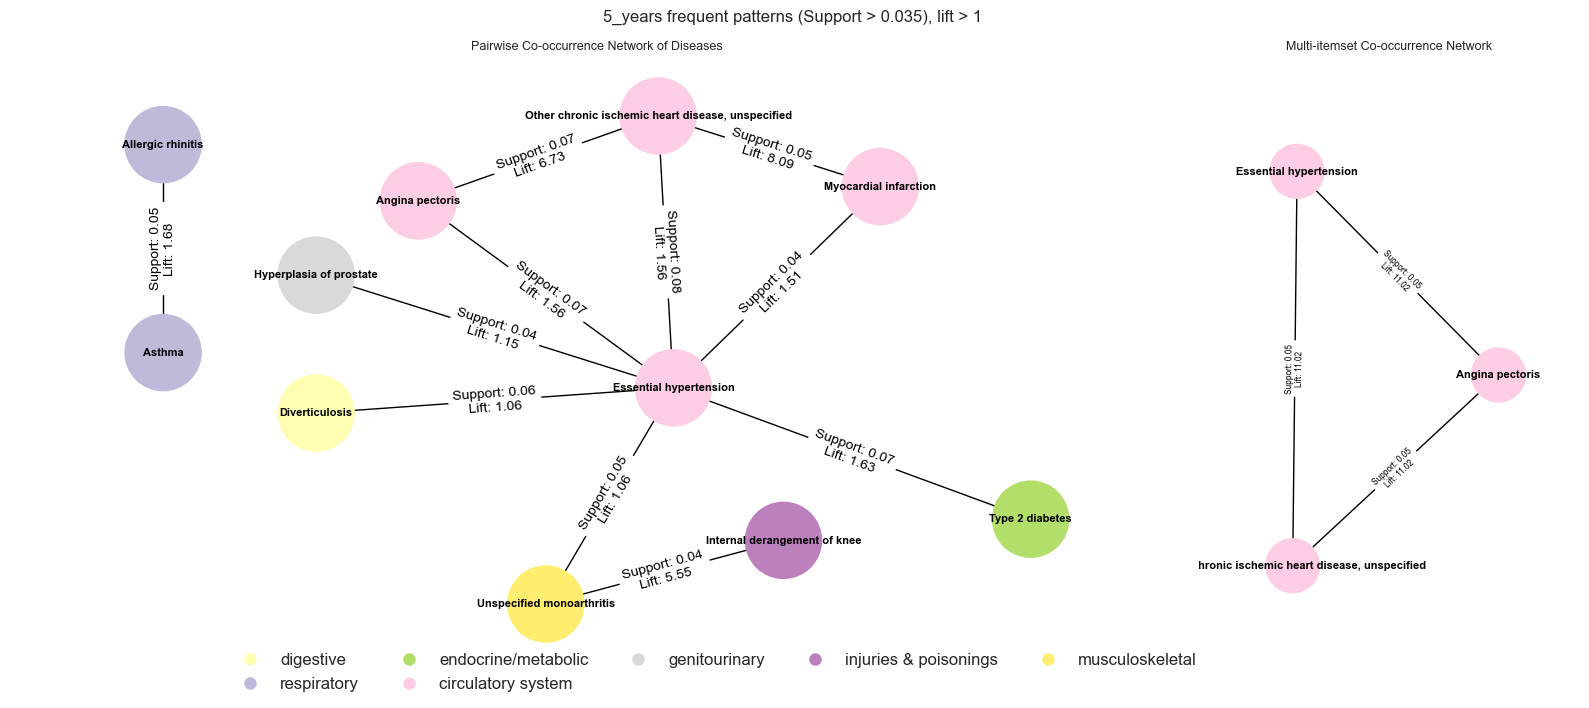

In [273]:
# Determine the number of multi-itemsets and calculate rows
num_multi_itemsets = len(multi_itemsets)
num_rows = num_multi_itemsets  # Two multi-itemsets per row, calculate number of rows

# Create the figure with pairwise graph on the left and multi-itemsets on the right
#fig, axes = plt.subplots(num_rows, 2, figsize=(15, 7 * num_rows), gridspec_kw={'width_ratios': [3, 1]})
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(16)

axes =[]
axes.append( plt.subplot2grid(shape=(num_rows, 4), loc=(0, 0), colspan=3,rowspan=num_rows))


for i in range(num_rows):
   axes.append(plt.subplot2grid(shape=(num_rows, 4), loc=(i, 3), colspan=1,rowspan=1))



# Plot pairwise itemsets (always in the first subplot on the left)
ax = axes[0]

pairwise_positions = pairwise_positions_fixed
ax.set_xlim(-1.1, 1.20)
ax.set_ylim(-1.362, 1.571)

node_colors = [chapter_colors[node_chapters[node]] for node in G_pairwise.nodes]
nx.draw(G_pairwise, pairwise_positions, with_labels=True, node_size=3000, node_color=node_colors, font_size=8, font_weight='bold', ax=ax)

# Draw edge labels for pairwise itemsets (Support and Lift)
edge_labels_pairwise = nx.get_edge_attributes(G_pairwise, 'weight')  # support as edge weight
lift_labels_pairwise = nx.get_edge_attributes(G_pairwise, 'lift')  # lift stored separately
combined_labels_pairwise = {key: f"Support: {edge_labels_pairwise[key]:.2f}\nLift: {lift_labels_pairwise[key]:.2f}"
                            for key in edge_labels_pairwise}
nx.draw_networkx_edge_labels(G_pairwise, pairwise_positions, edge_labels=combined_labels_pairwise, ax=ax)

ax.set_title(f'Pairwise Co-occurrence Network of Diseases',size=9)

# Plot multi-itemsets (one per subplot) in the right side, stacking them two per row
for i, (itemset, support, lift) in enumerate(multi_itemsets):
    ax = axes[i + 1]  # Get the correct subplot for this multi-itemset

    # Create a subgraph for the multi-itemset
    G_multiitemset = nx.Graph()
    for (disease1, disease2) in itertools.combinations(itemset, 2):
        G_multiitemset.add_edge(disease1, disease2, weight=support, lift=lift)

    # Apply spring layout to multi-itemset with a smaller 'k' value to rescale positions
    multi_itemset_positions = nx.spring_layout(G_multiitemset, k=0.2, seed=715)
    
    ax.set_xlim(-1.208, 1.600)
    ax.set_ylim(-1.362, 1.371)

    # Draw the multi-itemset
    node_colors=[chapter_colors[node_chapters[node]] for node in G_multiitemset.nodes]
    nx.draw(G_multiitemset, multi_itemset_positions, with_labels=True, node_size=1500, node_color=node_colors, font_size=8, font_weight='bold', ax=ax,alpha=1)

    # Draw edge labels for multi-itemset (Support and Lift)
    edge_labels_multiitemset = nx.get_edge_attributes(G_multiitemset, 'weight')  # support as edge weight
    lift_labels_multiitemset = nx.get_edge_attributes(G_multiitemset, 'lift')  # lift stored separately
    combined_labels_multiitemset = {key: f"Support: {edge_labels_multiitemset[key]:.2f}\nLift: {lift_labels_multiitemset[key]:.2f}"
                                    for key in edge_labels_multiitemset}
    nx.draw_networkx_edge_labels(G_multiitemset, multi_itemset_positions, edge_labels=combined_labels_multiitemset, ax=ax, font_size=6)
    if i==0:
        ax.set_title(f'Multi-itemset Co-occurrence Network',fontsize=9)
    
#  Create a legend at the bottom for only valid chapters
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=chapter_colors[chapter], markersize=10, label=chapter)
                 for chapter in set([node_chapters[node] for node in G_pairwise.nodes])]

fig.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.45, -0.015), ncol=5, fontsize=12, frameon=False)


# Adjust layout
fig.suptitle(f'{year_type} frequent patterns (Support > {threshold}), lift > 1 ')
fig.subplots_adjust(top=0.95,bottom=0.2) 
# Adjust the title position
plt.tight_layout()
fig.savefig(params.data_path.parents[3] / f'plot/post_cluster_analysis/frequent_patterns_{year_type}.pdf')

# by chapters 

In [14]:
year_type = '10_years'
multi_cluster_labels = {'pre_recruit':2,
                       '5_years':2,
                        '10_years':1}

df_analyse=pd.read_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_{year_type}.pkl')


# marking percentage of single diseases, 2 diseases and more than 2 conditions 
disease_columns = [x for x in df_analyse.columns if 'd_' in x] 
multi_condition_data = df_analyse[df_analyse[f'cluster_{year_type}'] == multi_cluster_labels[year_type]][disease_columns+['diseases_count']]

df_phe_db = pd.read_csv(final_data_path.parents[1]/'Data/intermediate_files/all_icd_phecode.csv')
multi_cluster_disease_explore = multi_condition_data[disease_columns].sum(axis=0).reset_index().rename(columns={'index':'disease',0:'counts'}).sort_values(by='counts',ascending=False)
multi_cluster_disease_explore['disease_name'] =  [get_phecode_description(x, df_phe_db) for  x in multi_cluster_disease_explore.disease]
multi_cluster_disease_explore['category'] = [get_phecode_description(x, df_phe_db,'category') for  x in multi_cluster_disease_explore.disease]
multi_cluster_disease_explore=update_disease_counts(multi_condition_data, multi_cluster_disease_explore)

In [15]:
from mlxtend.frequent_patterns import apriori, association_rules
df_frequent_tiemsets = pd.DataFrame()



In [82]:
chapter_colors = {'neoplasms': (0.5529411764705883, 0.8274509803921568, 0.7803921568627451, 1.0), 'digestive': (1.0, 1.0, 0.7019607843137254, 1.0), 'respiratory': (0.7450980392156863, 0.7294117647058823, 0.8549019607843137, 1.0), 'hematopoietic': (0.984313725490196, 0.5019607843137255, 0.4470588235294118, 1.0), 'neurological': (0.5019607843137255, 0.6941176470588235, 0.8274509803921568, 1.0), 'endocrine/metabolic': (0.7019607843137254, 0.8705882352941177, 0.4117647058823529, 1.0), 'circulatory system': (0.9882352941176471, 0.803921568627451, 0.8980392156862745, 1.0), 'genitourinary': (0.8509803921568627, 0.8509803921568627, 0.8509803921568627, 1.0), 'injuries & poisonings': (0.7372549019607844, 0.5019607843137255, 0.7411764705882353, 1.0), 'mental disorders': (0.8, 0.9215686274509803, 0.7725490196078432, 1.0), 'musculoskeletal': (1.0, 0.9294117647058824, 0.43529411764705883, 1.0)}


In [16]:
phe_cate_dict = {y:x for x,y in params.phe_cate_dict_fo.items()}
for cate in phe_cate_dict.keys():
    skip_sign=False
    
    if len(df_frequent_tiemsets)==0:
        skip_sign=False
    else:
        if (len(df_frequent_tiemsets)>0) & len(df_frequent_tiemsets.loc[(df_frequent_tiemsets['category']==phe_cate_dict[cate]) & (df_frequent_tiemsets['year_type']==year_type),'itemsets'])>0:
            skip_sign=True
    
    if not skip_sign:
    
    
        cate_name = phe_cate_dict[cate]
        chapter_threshold = 0.05 # 5% of the diseases
        
        multi_cluster_disease_explore_chapter=multi_cluster_disease_explore.loc[multi_cluster_disease_explore['category']==cate_name,]
        total = multi_cluster_disease_explore_chapter['counts'].sum()
        selected_diseases = multi_cluster_disease_explore_chapter.loc[multi_cluster_disease_explore_chapter['counts']>total*chapter_threshold,'disease'].tolist()
        print(f" cate: {cate_name}, total counts of {cate_name}= {total}, threshold={chapter_threshold}, {len(selected_diseases)} diseases left")
        print(f'selected diseases: {selected_diseases}')
        
        multi_cluster_disease_explore_selected = multi_cluster_disease_explore.loc[multi_cluster_disease_explore['disease'].isin(selected_diseases)].reset_index(drop=True)
        
        # Filter the co-occurrence matrix to show only correlations above 0.5
        multi_condition_data = df_analyse.loc[df_analyse[f'cluster_{year_type}'] == multi_cluster_labels[year_type],disease_columns]
        #multi_condition_data.columns = [get_phecode_description(x,df_phe_db) for x in multi_condition_data.columns]
        co_occurrence = multi_condition_data.corr()
    
        
        # selecting diseases related to the chapter's top prevalent diseases 
        threshold=0.01
        temp = co_occurrence[selected_diseases] 
        diseases_relate_to_the_chapter =  temp[(co_occurrence > threshold)].dropna(axis=1, how='all').dropna(axis=0, how='all').reset_index()['index'].tolist()
        print(f'there are {len(diseases_relate_to_the_chapter)} diseases related to the chapter')
        
        # frequent itemset 
        
        multi_condition_data = df_analyse[(df_analyse[f'cluster_{year_type}'] == multi_cluster_labels[year_type]) & (df_analyse['diseases_count']>1)]
        
        disease_data = multi_condition_data.loc[multi_condition_data['diseases_count']>1,selected_diseases+diseases_relate_to_the_chapter]
        # Convert to 0/1 (binary) format
        disease_data = disease_data.apply(lambda x: x.astype(bool))
        disease_data.columns = [get_phecode_description(x,df_phe_db) for x in disease_data.columns]
        # Apply the Apriori algorithm
        frequent_itemsets = apriori(disease_data, min_support=0.01, use_colnames=True)
        
        item_support = disease_data.mean()  # This gives the support of each individual item
        
        # Add Lift to frequent itemsets
        def calculate_lift(itemset, item_support, frequent_itemsets):
            """
            Calculate lift for a given itemset
            """
            # Get the support of the itemset
            itemset_support = frequent_itemsets.loc[frequent_itemsets['itemsets'] == itemset, 'support'].values[0]
            
            # Calculate the lift for the itemset
            lift = itemset_support / (item_support[list(itemset)].prod())
            return lift
        
        # Apply the calculate_lift function to each itemset
        frequent_itemsets['lift'] = frequent_itemsets['itemsets'].apply(lambda x: calculate_lift(x, item_support, frequent_itemsets))
        frequent_itemsets['year_type']=year_type
        frequent_itemsets['category'] = cate_name
        
        
        if not isinstance(df_frequent_tiemsets,pd.DataFrame):
            df_frequent_tiemsets = pd.DataFrame()
        else:
            df_frequent_tiemsets=pd.concat([df_frequent_tiemsets,frequent_itemsets]).reset_index(drop=True)
            

 cate: infectious diseases, total counts of infectious diseases= 5981.0, threshold=0.05, 2 diseases left
selected diseases: ['d_54.0', 'd_71.1']
there are 28 diseases related to the chapter
 cate: neoplasms, total counts of neoplasms= 90850.0, threshold=0.05, 4 diseases left
selected diseases: ['d_172.2', 'd_174.11', 'd_185.0', 'd_172.11']
there are 32 diseases related to the chapter
 cate: endocrine/metabolic, total counts of endocrine/metabolic= 75881.0, threshold=0.05, 5 diseases left
selected diseases: ['d_250.2', 'd_274.1', 'd_242.0', 'd_275.0', 'd_250.1']
there are 141 diseases related to the chapter
 cate: hematopoietic, total counts of hematopoietic= 29308.0, threshold=0.05, 2 diseases left
selected diseases: ['d_280.1', 'd_281.12']
there are 99 diseases related to the chapter
 cate: mental disorders, total counts of mental disorders= 77946.0, threshold=0.05, 2 diseases left
selected diseases: ['d_296.2', 'd_316.0']
there are 100 diseases related to the chapter
 cate: neurologi

In [17]:
df_frequent_tiemsets['item_length'] = df_frequent_tiemsets['itemsets'].apply(lambda x: len(x))
df_frequent_tiemsets.to_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/frequent_itemsets_{year_type}.pkl')

In [19]:
df_frequent_tiemsets = pd.DataFrame()
for year_type in ['pre_recruit','5_years','10_years']:
    df_frequent_tiemsets = pd.concat([df_frequent_tiemsets,pd.read_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/frequent_itemsets_{year_type}.pkl')],axis=0)
    df_frequent_tiemsets.reset_index(inplace=True,drop=True)
    
# only keep more than 2 items 
df_frequent_tiemsets = df_frequent_tiemsets.loc[df_frequent_tiemsets['item_length']>1,]

phe_cate_dict_rev = {y:x for x,y in phe_cate_dict.items()}
df_frequent_tiemsets['category_num'] = [phe_cate_dict_rev[x] for x in df_frequent_tiemsets['category']]

In [493]:
threshold

0.02

In [273]:
import numpy as np 
customised_positions={2: {"Myocardial infarction":np.array([0.87987976, 0.83415666]),
                          "Diverticulosis":np.array([-0.64,  0.6640496]),
                          "Hyperplasia of prostate":np.array([-1,  -0.3])},
                      3: {'Other chronic ischemic heart disease, unspecified': np.array([-0.50534505,  1.2472366])},
                      5: {'Irritable Bowel Syndrome': np.array([1 , -0.1])},
                      9:{'Essential hypertension': np.array([ 0.0103719, -1.2] ),
                         'Allergic rhinitis': np.array([ 1 , -0.8]),
                         'Unspecified monoarthritis': np.array([1, 0.5] ),
                         'Other chronic ischemic heart disease, unspecified': np.array([0.47841419, 1 ]),},
                      10:{'Depression': np.array([-0.1, 1.3]),
                          'Angina pectoris': np.array([-0.45,  -0.8416387]),
                          'Type 2 diabetes': np.array([ -1.5, -0.1]),
                          'Irritable Bowel Syndrome': np.array([1.5, 1]),
                          'Other disorders of intestine': np.array([0.32, 0.85]),
                          'Asthma': np.array([0.90903819, 0.3]),
                          'Essential hypertension': np.array([ 0.95, -0.5]),
                          'Spondylosis and allied disorders': np.array([-0.9,  0.9]),
                          'Unspecified monoarthritis': np.array([-1.3,  0.43554762] )},
                      14:{'Spondylosis and allied disorders': np.array([-0.0944728 ,  1]),
                          'Unspecified monoarthritis': np.array( [ 0.02368722,-0.6]),
                          "Diverticulosis":np.array([0.1, 0.2]),
                          'Internal derangement of knee': np.array([ 0.8, -1.2]),
                           'Osteoarthritis; localized': np.array([-1,  0.59005736]),
                          'Depression': np.array([0.9 , 0.67549429]),
                          }}
customised_lims = {1: {'x':[-1.5,1.8],"y":[-1.5,1.8],'k':0.8, "seed":1918},
                   2: {'x':[-1.5,1.8],"y":[-1.5,1.8],'k':0.8, "seed":1918},
                   3: {'x':[-1.5,1.8],"y":[-1.5,1.8],'k':0.8, "seed":1777},
                   4: {'x':[-1.5,1.8],"y":[-1.5,1.8],'k':0.8, "seed":1755},
                   5: {'x':[-1.5,1.8],"y":[-1.5,1.8],'k':0.8, "seed":1755},
                   6: {'x':[-1.5,1.8],"y":[-1.5,1.8],'k':0.8, "seed":1755},
                   7: {'x':[-1.5,1.8],"y":[-1.5,1.8],'k':0.8, "seed":1755},
                   8: {'x':[-1.5,1.8],"y":[-1.5,1.5],'k':1, "seed":1755},
                   9: {'x':[-1.5,1.8],"y":[-1.5,1.5],'k':0.9, "seed":8152},
                   10: {'x':[-1.9,2],"y":[-1.5,1.5],'k':1, "seed":165},
                   11: {'x':[-1.9,2],"y":[-1.5,1.5],'k':1, "seed":165},
                   12: {'x':[-1.9,2],"y":[-1.5,1.5],'k':1, "seed":165},
                   13: {'x':[-1.9,2],"y":[-1.5,1.5],'k':1, "seed":165},
                   14: {'x':[-1.9,2],"y":[-1.5,1.5],'k':1, "seed":1825},
                   15: {'x':[-1.9,2],"y":[-1.5,1.5],'k':1, "seed":1825},
                   17: {'x':[-1.9,2],"y":[-1.5,1.5],'k':1, "seed":1825},
                   18: {'x':[-1.9,2],"y":[-1.5,1.5],'k':1, "seed":1825},}
category_num = 17

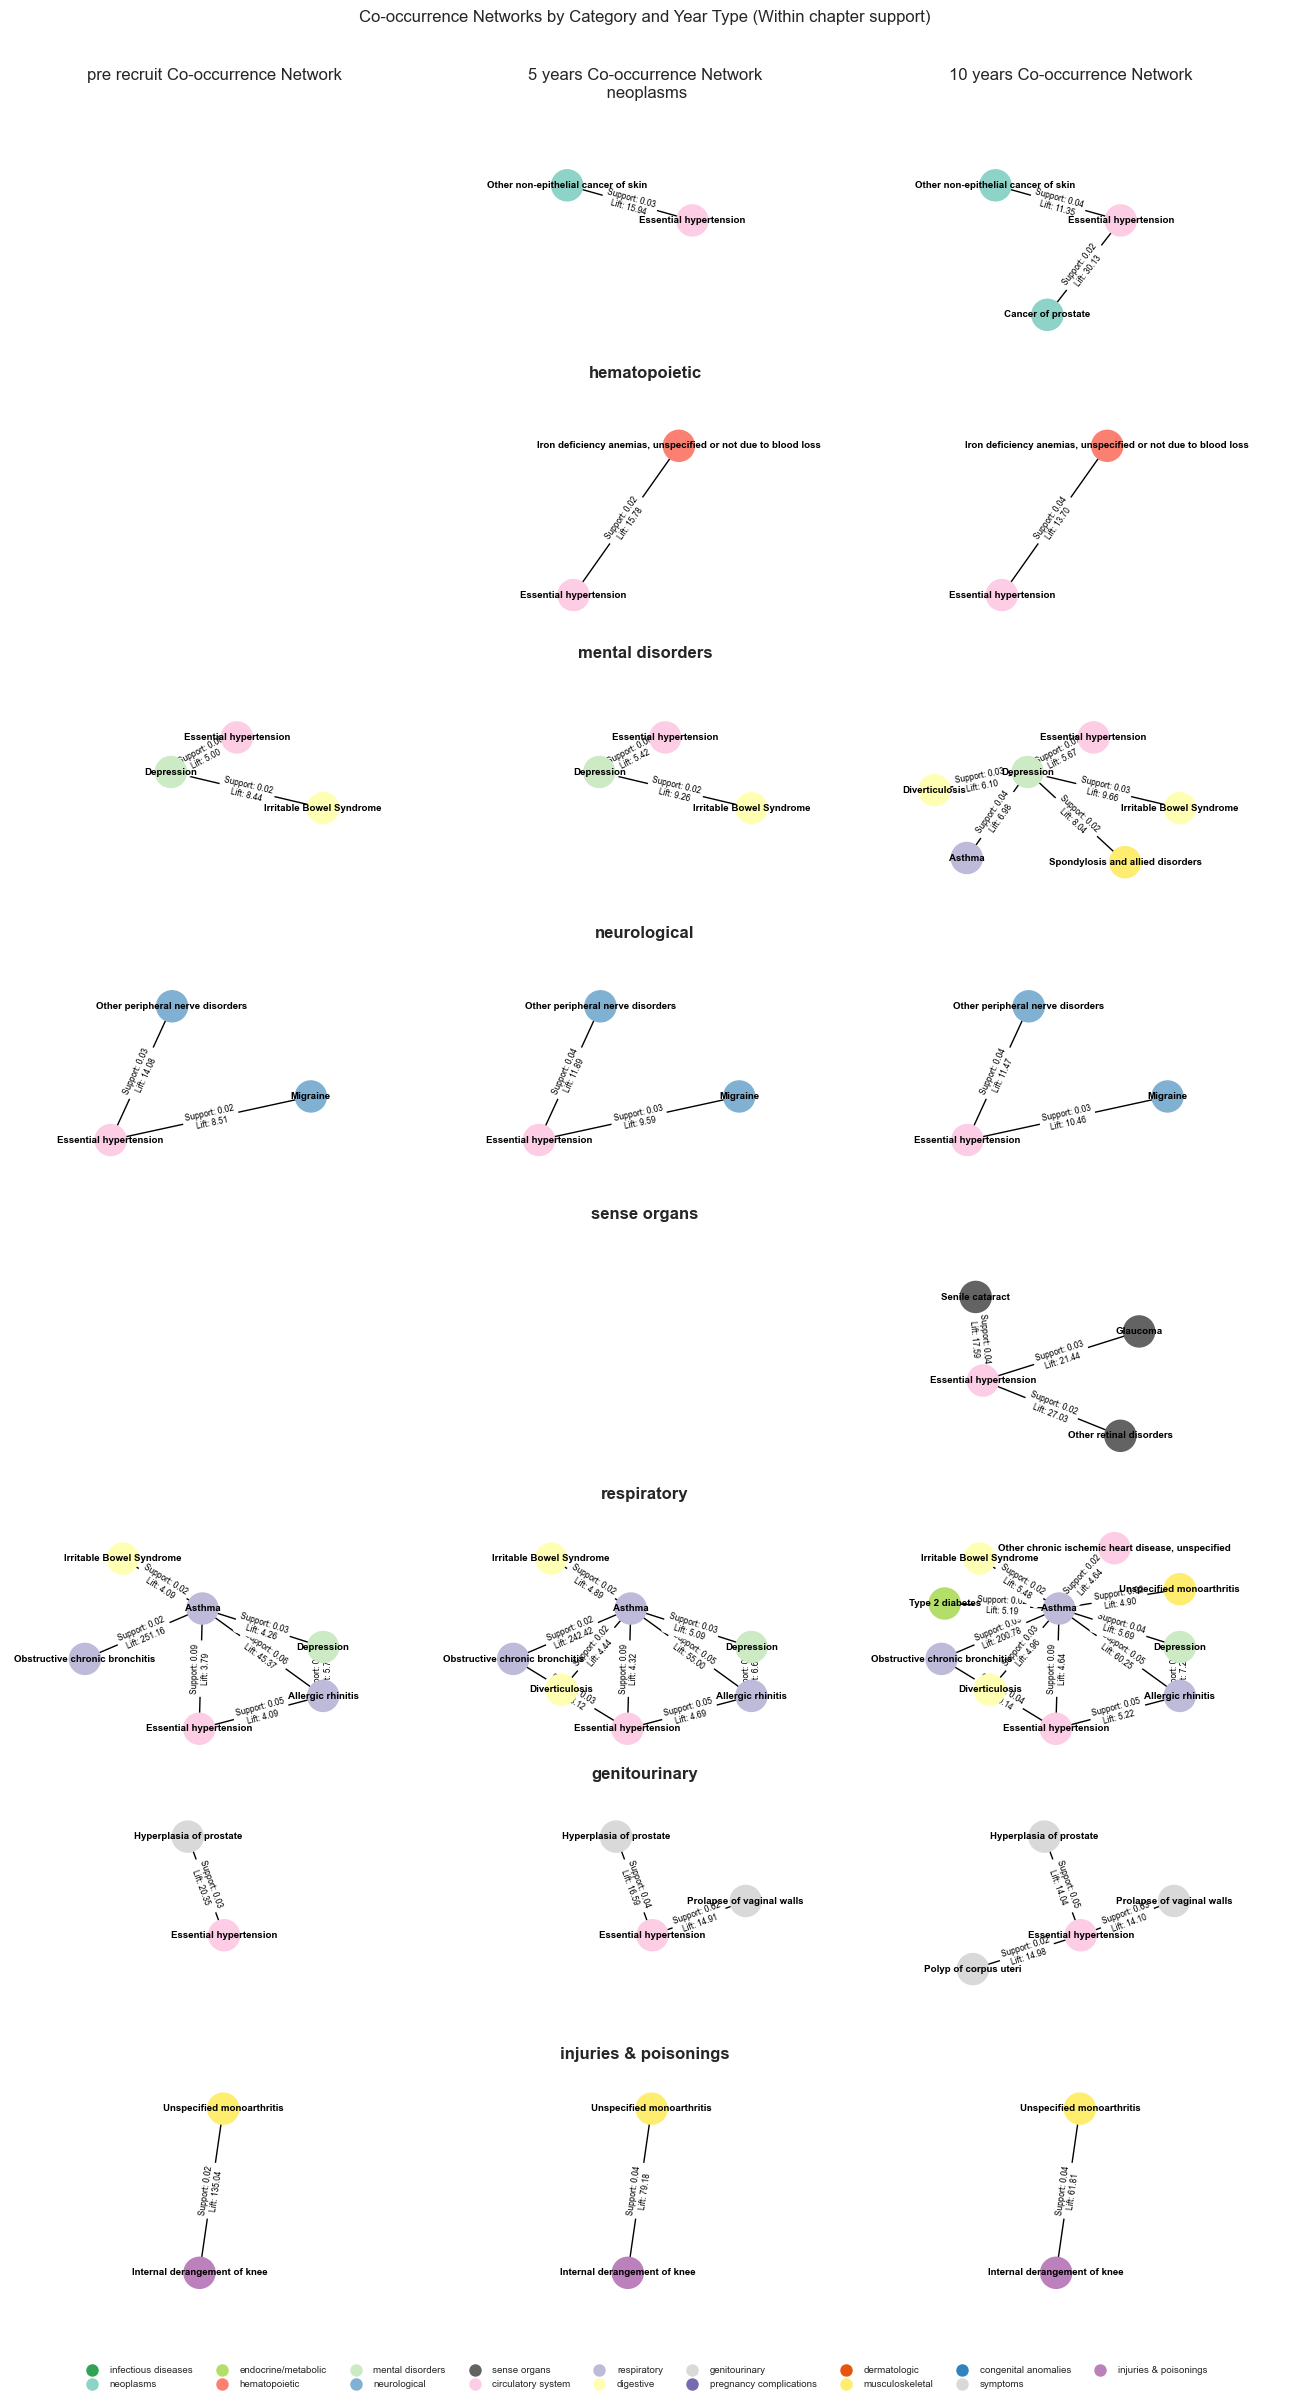

In [303]:
import matplotlib.pyplot as plt
import networkx as nx
import itertools

# Example: Your frequent_itemsets dataframe
frequent_itemsets = df_frequent_tiemsets.copy()
# Get unique categories and year types
categories = df_frequent_tiemsets['category'].unique()
year_types = ['10_years','pre_recruit', '5_years']  # Ensure this is in the correct order
ax_order={"10_years":2,"pre_recruit":0,"5_years":1}



# Create a figure for each category

categories_to_put_together = [2,4,5,6,7,9,11,18]

# Filter the data for this category

# Create a figure with 3 subplots for each year_type (one for each year)
fig, axes = plt.subplots(len(categories_to_put_together), 3, figsize=(13,3*len(categories_to_put_together)), gridspec_kw={'width_ratios': [1, 1, 1]})
fig.suptitle('Co-occurrence Networks by Category and Year Type (Within chapter support)')

for i, category_num in enumerate(categories_to_put_together):
    category_data = frequent_itemsets[frequent_itemsets['category_num'] == category_num]
    
    # Loop over the year_types and create a plot for each
    for year_type in year_types:
        node_chapters = {}
    
        
        ax = axes[i, ax_order[year_type]]  # Get the appropriate subplot
        
        diseases_in_the_chapter = df_phe_db.loc[df_phe_db['category']==phe_cate_dict[category_num],'description'].tolist()
        # Filter data by the current year_type
        year_data = category_data[(category_data['year_type'] == year_type) & (category_data['lift'] >1)& (category_data['support'] > threshold)]
        year_data = year_data[
        year_data['itemsets'].apply(lambda x: any(disease in diseases_in_the_chapter for disease in x))]
        
    
        # Create the graph for this year_type
        G = nx.Graph()
        
        # Add edges for the itemsets in the filtered data
        for idx, row in year_data.iterrows():
            itemset = row['itemsets']
            support = row['support']
            lift = row['lift']
            
            # For pairwise itemsets (2 items), directly add the edges
            if len(itemset) == 2:
                disease1, disease2 = list(itemset)
                G.add_edge(disease1, disease2, weight=support, lift=lift)
                for disease in itemset:
                    if disease not in node_chapters.keys():
                        node_chapters[disease] = df_phe_db.loc[df_phe_db['description']==disease,'category'].values[0]
            
            # For multi-itemsets (3 or more items), store them for separate visualization
            elif len(itemset) > 2:
                #for (disease1, disease2) in itertools.combinations(itemset, 2):
                #    G.add_edge(disease1, disease2, weight=support, lift=lift)
                print(itemset)
        
                # Generate positions for the 10_years (third subplot)
            if year_type == '10_years':
                positions = nx.spring_layout(G, k=customised_lims[category_num]['k'], seed=customised_lims[category_num]['seed'])
                # Store positions for later use in other subplots
                fixed_positions = positions
            else:
                # For other subplots (pre_recruit and 5_years), reuse the positions from the 10_years subplot
                positions = nx.spring_layout(G,  k=customised_lims[category_num]['k'], seed=customised_lims[category_num]['seed'])
                for key in fixed_positions.keys():
                    positions[key] = fixed_positions[key]
            
            if category_num in customised_positions.keys():
                
                for labels in customised_positions[category_num].keys():
                    positions[labels]=customised_positions[category_num][labels]
                    
        # define node color 
        node_colors=[chapter_colors[node_chapters[node]] for node in G.nodes]
        
        # Draw the network for this year_type
        nx.draw(G, positions, with_labels=True, node_size=500, node_color=node_colors, font_size=7, font_weight='bold', ax=ax)
        
        # Add edge labels (Support and Lift)
        edge_labels = nx.get_edge_attributes(G, 'weight')  # support as edge weight
        lift_labels = nx.get_edge_attributes(G, 'lift')  # lift stored separately
        combined_labels = {key: f"Support: {edge_labels[key]:.2f}\nLift: {lift_labels[key]:.2f}"
                           for key in edge_labels}
        nx.draw_networkx_edge_labels(G, positions, edge_labels=combined_labels, ax=ax,font_size=6)
        if i==0:
            ax.set_title(f'{year_type.replace("_"," ")} Co-occurrence Network \n')
        
        if ax_order[year_type]==1:
            if i ==0:
                ax.set_title(f'{year_type.replace("_"," ")} Co-occurrence Network\n {phe_cate_dict[category_num]}')
            else:
                ax.set_title(f"{phe_cate_dict[category_num]}",fontweight='bold')
        
        # Set the title for the current year_type plot
        
        ax.set_xlim(customised_lims[category_num]['x'])
        ax.set_ylim(customised_lims[category_num]['y'])
# Adjust layout for a neat display
#  Create a legend at the bottom for only valid chapters
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=chapter_colors[chapter], markersize=10, label=chapter)
                 for chapter in phe_cate_dict_rev.keys()]

fig.legend(handles=legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.015), ncol=9, fontsize=7, frameon=False)

plt.tight_layout()
plt.subplots_adjust(top=0.94,bottom=0.02)  # Adjust the title to avoid overlap  # Show the plots for this category
fig.savefig(params.data_path.parents[3] / f'plot/post_cluster_analysis/frequent_patterns_1.pdf')
# You can save the plot as well, e.g.:
# fig.savefig(f'category_{category}_network.png')

## category=3, endocrine 

frozenset({'Essential hypertension', 'Angina pectoris', 'Type 2 diabetes'})
frozenset({'Essential hypertension', 'Other chronic ischemic heart disease, unspecified', 'Type 2 diabetes'})
0 2
1 2


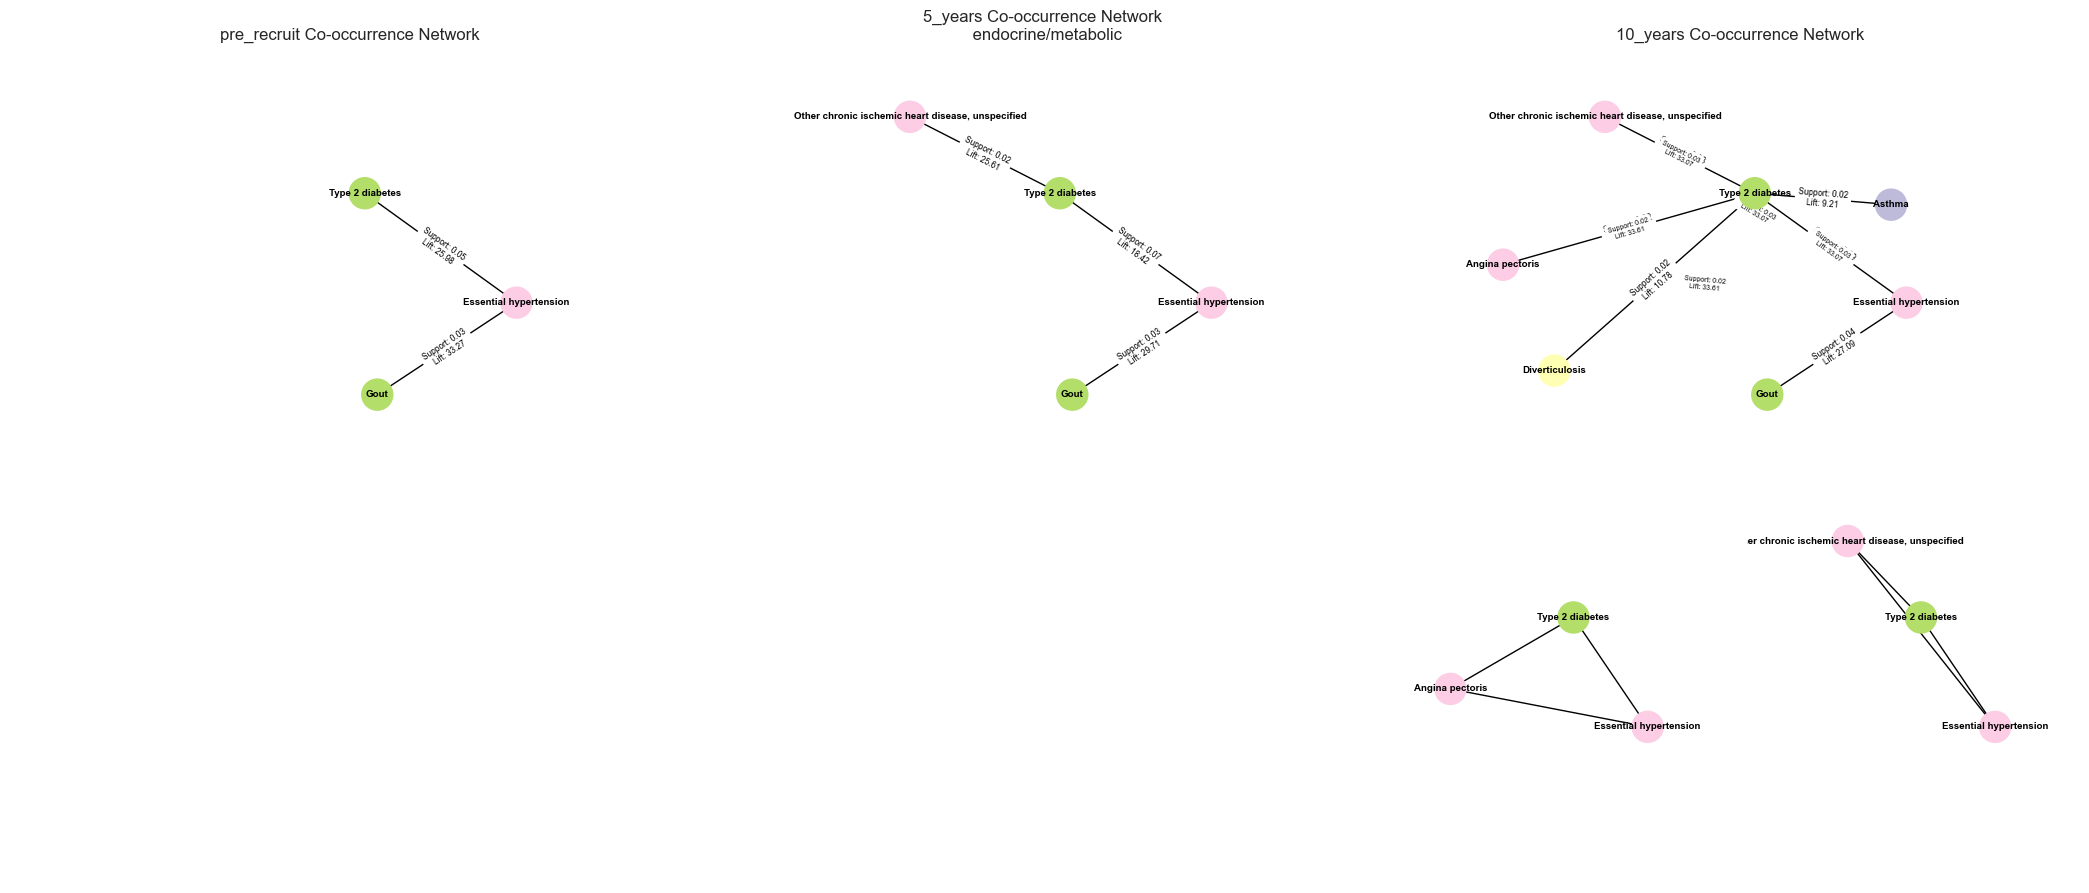

frozenset({'Diverticulosis', 'Essential hypertension', 'Other disorders of intestine'})
frozenset({'Diverticulosis', 'Other chronic ischemic heart disease, unspecified', 'Essential hypertension'})
0 2
1 2


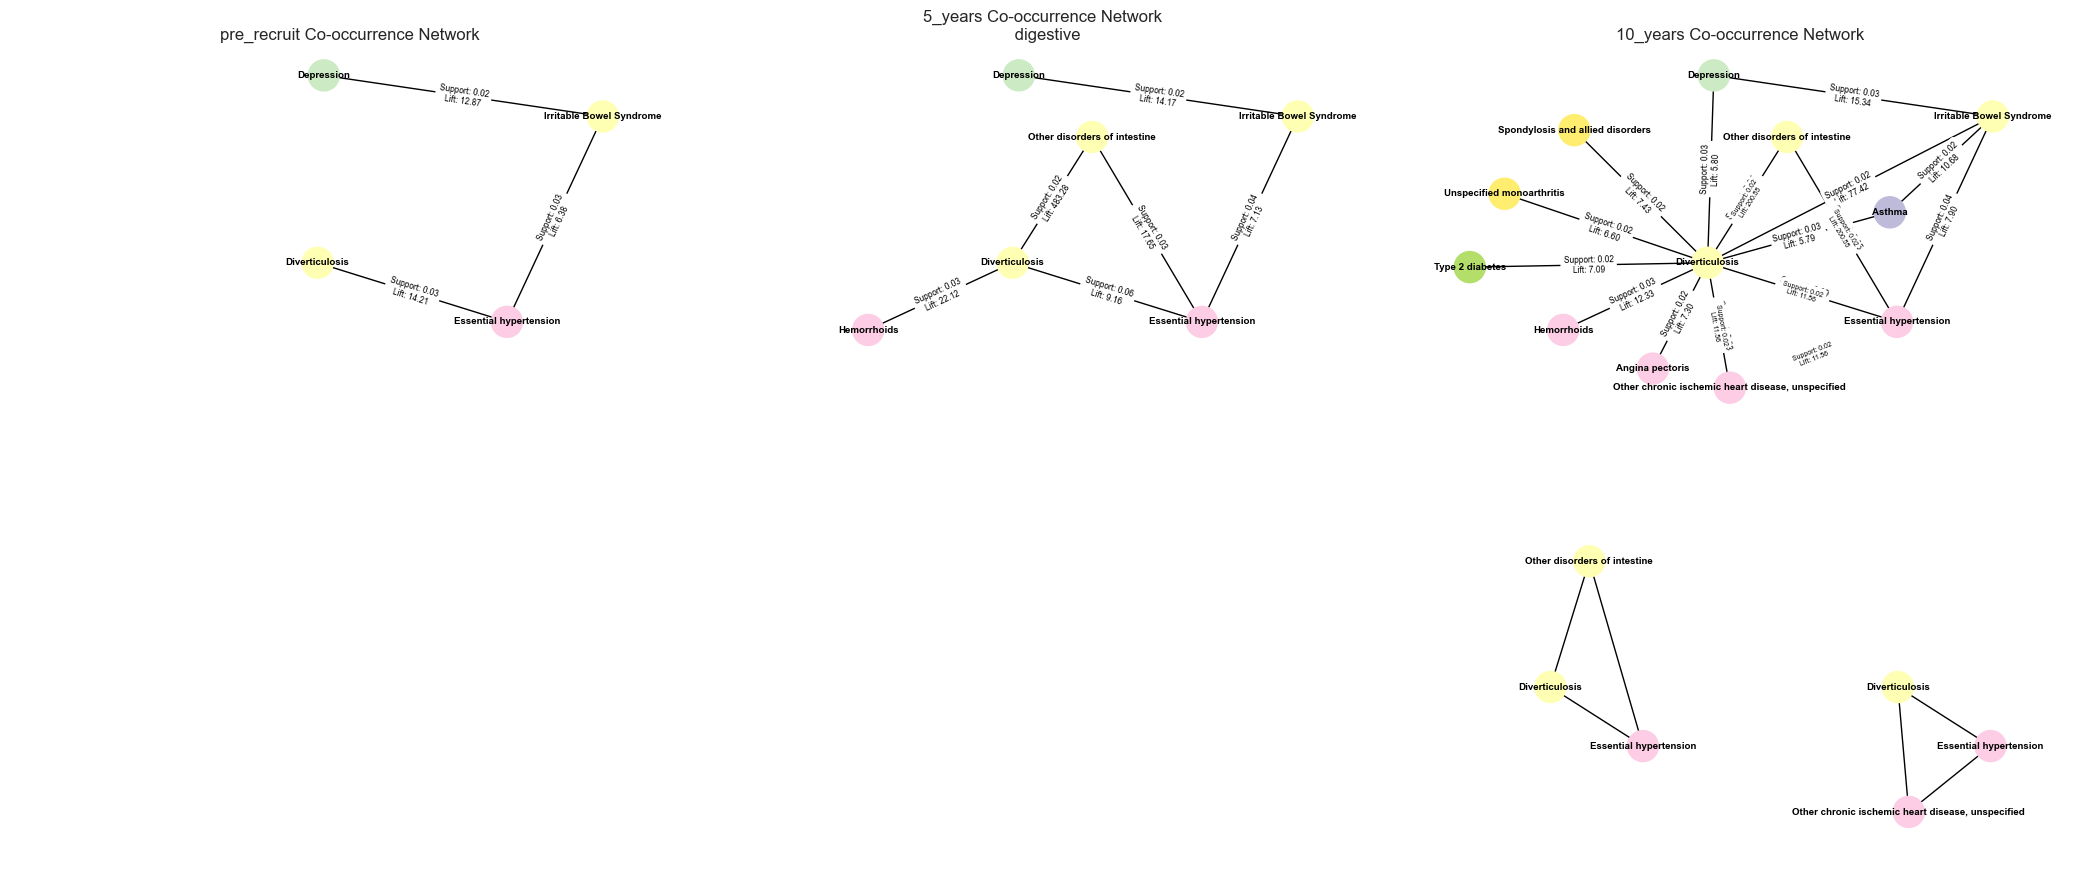

frozenset({'Essential hypertension', 'Other chronic ischemic heart disease, unspecified', 'Angina pectoris'})
frozenset({'Essential hypertension', 'Other chronic ischemic heart disease, unspecified', 'Myocardial infarction'})
frozenset({'Essential hypertension', 'Other chronic ischemic heart disease, unspecified', 'Diverticulosis'})
frozenset({'Essential hypertension', 'Other chronic ischemic heart disease, unspecified', 'Type 2 diabetes'})
frozenset({'Essential hypertension', 'Angina pectoris', 'Myocardial infarction'})
frozenset({'Essential hypertension', 'Angina pectoris', 'Type 2 diabetes'})
frozenset({'Essential hypertension', 'Other disorders of intestine', 'Diverticulosis'})
frozenset({'Other chronic ischemic heart disease, unspecified', 'Angina pectoris', 'Myocardial infarction'})
frozenset({'Essential hypertension', 'Other chronic ischemic heart disease, unspecified', 'Angina pectoris', 'Myocardial infarction'})
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
frozenset({'Essential hyperte

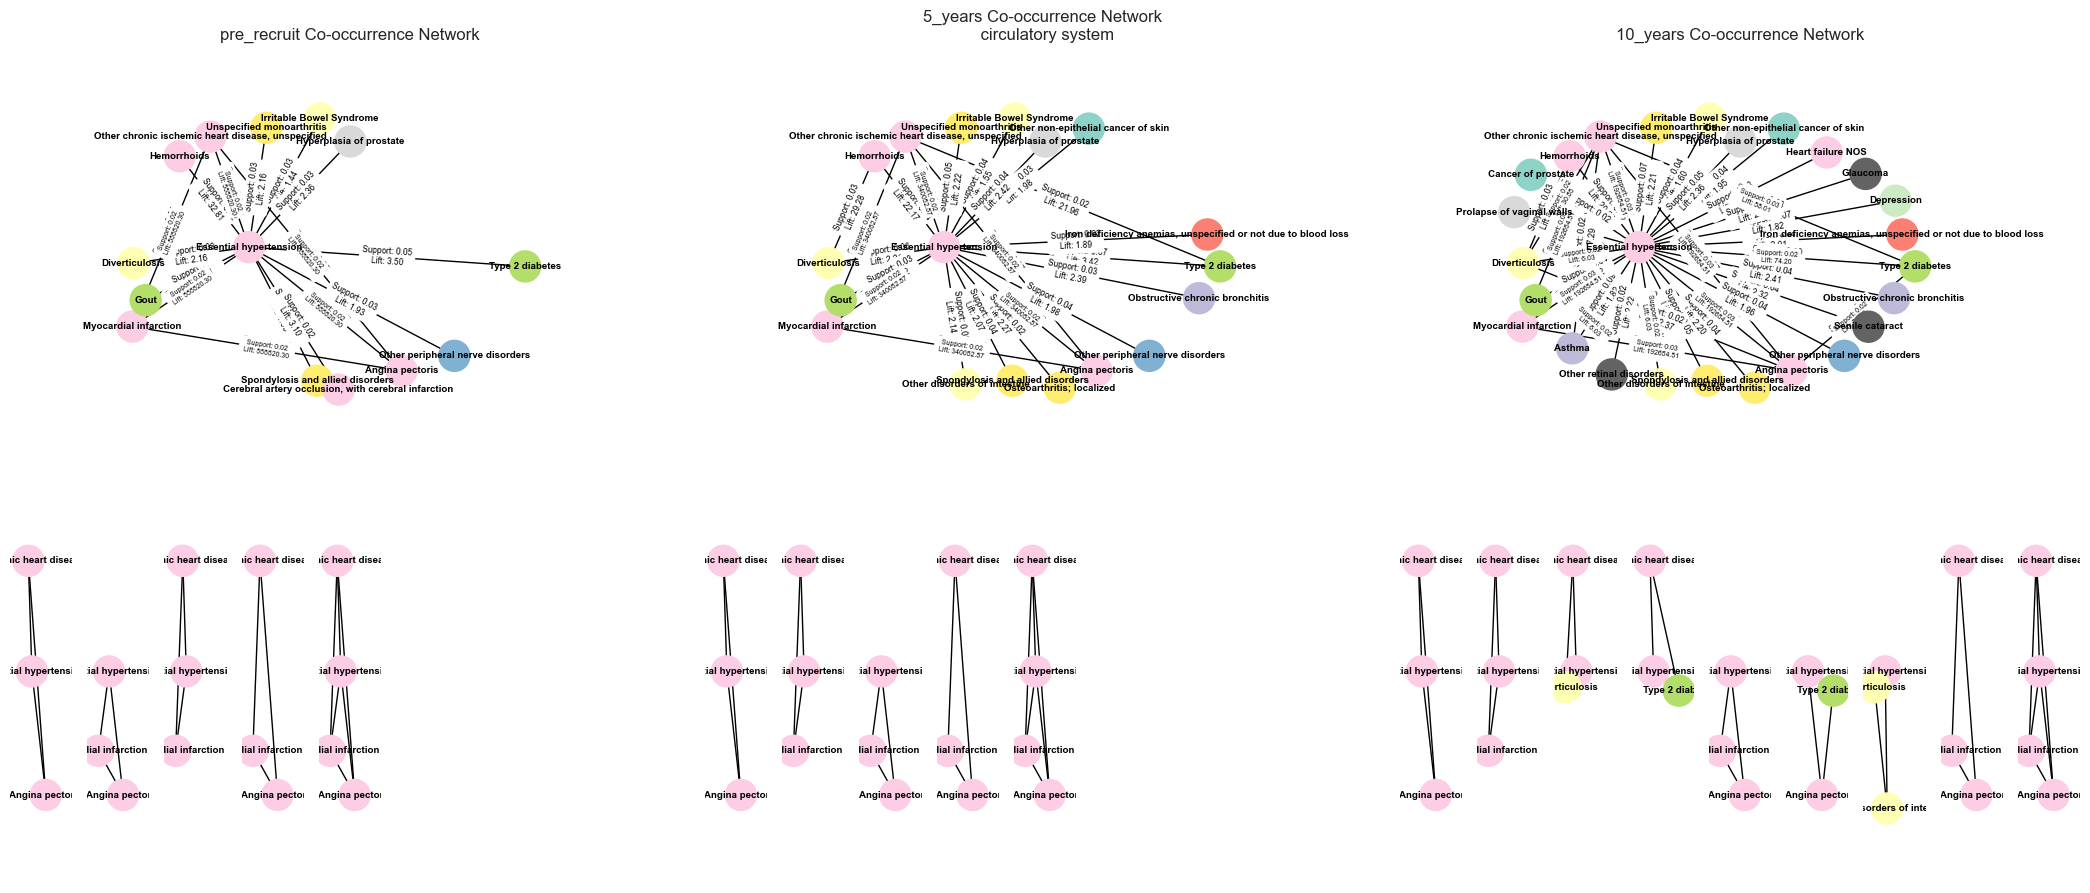

In [342]:
import matplotlib.pyplot as plt
import networkx as nx
import itertools

# Example: Your frequent_itemsets dataframe
frequent_itemsets = df_frequent_tiemsets.copy()
# Get unique categories and year types
categories = df_frequent_tiemsets['category'].unique()
year_types = ['10_years','pre_recruit', '5_years']  # Ensure this is in the correct order
ax_order={"10_years":2,"pre_recruit":0,"5_years":1}


category_num=8


chapter_multi_item_size = {3:2,10:2,8:9}
for category_num in chapter_multi_item_size.keys():
    fig = plt.figure()
    fig.set_figheight(5*2)
    fig.set_figwidth(21)
    
    axes =[]
    axes.append(plt.subplot2grid(shape=(2, chapter_multi_item_size[category_num]*3), loc=(0, 0), colspan=chapter_multi_item_size[category_num],rowspan=1))
    axes.append(plt.subplot2grid(shape=(2, chapter_multi_item_size[category_num]*3), loc=(0, 1*chapter_multi_item_size[category_num]), colspan=chapter_multi_item_size[category_num],rowspan=1))
    axes.append(plt.subplot2grid(shape=(2, chapter_multi_item_size[category_num]*3), loc=(0, 2*chapter_multi_item_size[category_num]), colspan=chapter_multi_item_size[category_num],rowspan=1))
    
    
    for i in range(chapter_multi_item_size[category_num]*3):
       axes.append(plt.subplot2grid(shape=(2, chapter_multi_item_size[category_num]*3), loc=(1, i), colspan=1,rowspan=1))
    
    
    
    # Filter the data for this category
    category_data = frequent_itemsets[frequent_itemsets['category_num'] == category_num]
    
    
    # Loop over the year_types and create a plot for each
    for year_type in year_types:
        node_chapters = {}
    
        
        ax = axes[ax_order[year_type]]  # Get the appropriate subplot
        
        diseases_in_the_chapter = df_phe_db.loc[df_phe_db['category']==phe_cate_dict[category_num],'description'].tolist()
        # Filter data by the current year_type
        year_data = category_data[(category_data['year_type'] == year_type) & (category_data['lift'] >1)& (category_data['support'] > threshold)]
        year_data = year_data[
        year_data['itemsets'].apply(lambda x: any(disease in diseases_in_the_chapter for disease in x))]
        year_data=year_data.drop_duplicates(subset='itemsets')
    
        # Create the graph for this year_type
        G = nx.Graph()
        G_multiples = []
        positions_multiples=[]
        fixed_positions_multiples=[]
        #print('len G_multiples',len(G_multiples))
        # Add edges for the itemsets in the filtered data
        for idx, row in year_data.iterrows():
            itemset = row['itemsets']
            support = row['support']
            lift = row['lift']
            
            # For pairwise itemsets (2 items), directly add the edges
            if len(itemset) == 2:
                disease1, disease2 = list(itemset)
                G.add_edge(disease1, disease2, weight=support, lift=lift)
                for disease in itemset:
                    if disease not in node_chapters.keys():
                        node_chapters[disease] = df_phe_db.loc[df_phe_db['description']==disease,'category'].values[0]
            
            # For multi-itemsets (3 or more items), store them for separate visualization
            elif len(itemset) > 2:
                G_multiple=nx.Graph()
                print(itemset)
                for (disease1, disease2) in itertools.combinations(itemset, 2):
                    G_multiple.add_edge(disease1, disease2, weight=support, lift=lift)
                G_multiples.append(G_multiple)
            
            # pariwise itemsets 
            
            # Generate positions for the 10_years (third subplot)
            if year_type == '10_years':
                positions = nx.spring_layout(G, k=customised_lims[category_num]['k'], seed=customised_lims[category_num]['seed'])
                for i,G_multiple in enumerate(G_multiples):
                     positions_multiple =nx.spring_layout(G_multiple, k=customised_lims[category_num]['k'], seed=customised_lims[category_num]['seed'])
                     positions_multiples.append(positions_multiple)
                     fixed_positions_multiples.append(positions_multiple)
                # Store positions for later use in other subplots
                fixed_positions = positions
                
            else:
                # For other subplots (pre_recruit and 5_years), reuse the positions from the 10_years subplot
                positions = nx.spring_layout(G,  k=customised_lims[category_num]['k'], seed=customised_lims[category_num]['seed'])
                for key in fixed_positions.keys():
                    positions[key] = fixed_positions[key]
                    
                
                for i,G_multiple in enumerate(G_multiples):
                    positions_multiple = nx.spring_layout(G_multiple, k=customised_lims[category_num]['k'], seed=customised_lims[category_num]['seed'])
                
                    #for key in fixed_positions_multiples[i].keys():
                    #    positions_multiple= fixed_positions_multiples[i][key]
            
            if category_num in customised_positions.keys():
                
                for labels in customised_positions[category_num].keys():
                    positions[labels]=customised_positions[category_num][labels]
            
             
            
            
        # define node color 
        node_colors=[chapter_colors[node_chapters[node]] for node in G.nodes]
        # Draw the network for this year_type
        nx.draw(G, positions, with_labels=True, node_size=500, node_color=node_colors, font_size=7, font_weight='bold', ax=ax)
        
        # Add edge labels (Support and Lift)
        edge_labels = nx.get_edge_attributes(G, 'weight')  # support as edge weight
        lift_labels = nx.get_edge_attributes(G, 'lift')  # lift stored separately
        combined_labels = {key: f"Support: {edge_labels[key]:.2f}\nLift: {lift_labels[key]:.2f}"
                           for key in edge_labels}
        nx.draw_networkx_edge_labels(G, positions, edge_labels=combined_labels, ax=ax,font_size=6)
        
        starting_point=3+ax_order[year_type]*chapter_multi_item_size[category_num]
        for i,G_multiple in enumerate(G_multiples):
            print(i,ax_order[year_type])
            node_colors=[chapter_colors[node_chapters[node]] for node in G_multiple.nodes]
            nx.draw(G_multiple, positions, with_labels=True, node_size=500, node_color=node_colors, font_size=7, font_weight='bold', ax = axes[starting_point+i])
            axes[starting_point+i].set_xlim(customised_lims[category_num]['x'])
            axes[starting_point+i].set_ylim(customised_lims[category_num]['y'])
            edge_labels = nx.get_edge_attributes(G_multiple, 'weight')  # support as edge weight
            lift_labels = nx.get_edge_attributes(G_multiple, 'lift')  # lift stored separately
            combined_labels = {key: f"Support: {edge_labels[key]:.2f}\nLift: {lift_labels[key]:.2f}"
                           for key in edge_labels}
            nx.draw_networkx_edge_labels(G_multiple, positions, edge_labels=combined_labels, ax=ax,font_size=5)
        
        for m in range(len(G_multiples),chapter_multi_item_size[category_num]):
            axes[starting_point+m].set_visible(False)
        if year_type=='5_years':
            ax.set_title(f'{year_type} Co-occurrence Network \n {phe_cate_dict[category_num]}')
        else:
            ax.set_title(f'{year_type} Co-occurrence Network')
        ax.set_xlim(customised_lims[category_num]['x'])
        ax.set_ylim(customised_lims[category_num]['y'])
        #if len(G_multiples)==0:
        #    for i in range(chapter_multi_item_size[category_num]):
        #        axes[ax_order[year_type]+3+i].set_visible(False)
    # Adjust layout for a neat display
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the title to avoid overlap
    plt.show()  # Show the plots for this category
    


In [318]:
# Filter data by the current year_type
year_data = category_data[(category_data['year_type'] == year_type) & (category_data['lift'] >1)& (category_data['support'] > threshold)]
year_data = year_data[
year_data['itemsets'].apply(lambda x: any(disease in diseases_in_the_chapter for disease in x))]


# Count/level change 

In [441]:
year_type = 'pre_recruit'
multi_cluster_labels = {'pre_recruit':2,
                       '5_years':2,
                        '10_years':1}

df_analyse=pd.read_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_{year_type}.pkl')


# marking percentage of single diseases, 2 diseases and more than 2 conditions 
disease_columns = [x for x in df_analyse.columns if 'd_' in x] 
multi_condition_data = df_analyse[df_analyse[f'cluster_{year_type}'] == multi_cluster_labels[year_type]][disease_columns+['diseases_count']]

df_phe_db = pd.read_csv(final_data_path.parents[1]/'Data/intermediate_files/all_icd_phecode.csv')
multi_cluster_disease_explore = multi_condition_data[disease_columns].sum(axis=0).reset_index().rename(columns={'index':'disease',0:'counts'}).sort_values(by='counts',ascending=False)
multi_cluster_disease_explore['disease_name'] =  [get_phecode_description(x, df_phe_db) for  x in multi_cluster_disease_explore.disease]
multi_cluster_disease_explore['category'] = [get_phecode_description(x, df_phe_db,'category') for  x in multi_cluster_disease_explore.disease]
multi_cluster_disease_explore=update_disease_counts(multi_condition_data, multi_cluster_disease_explore)

year_type = '5_years'
df_analyse=pd.read_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_{year_type}.pkl')
multi_condition_data = df_analyse[df_analyse[f'cluster_{year_type}'] == multi_cluster_labels[year_type]][disease_columns+['diseases_count']]
multi_cluster_disease_explore_temp = multi_condition_data[disease_columns].sum(axis=0).reset_index().rename(columns={'index':'disease',0:'counts'}).sort_values(by='counts',ascending=False)
multi_cluster_disease_explore_temp=update_disease_counts(multi_condition_data, multi_cluster_disease_explore_temp)
multi_cluster_disease_explore = pd.merge(multi_cluster_disease_explore,multi_cluster_disease_explore_temp,on='disease',suffixes=['_pre_recruit','_5_years'])

year_type = '10_years'
df_analyse=pd.read_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/cluster_result_with_social_diseases_{year_type}.pkl')
multi_condition_data = df_analyse[df_analyse[f'cluster_{year_type}'] == multi_cluster_labels[year_type]][disease_columns+['diseases_count']]
multi_cluster_disease_explore_temp = multi_condition_data[disease_columns].sum(axis=0).reset_index().rename(columns={'index':'disease',0:'counts'}).sort_values(by='counts',ascending=False)
multi_cluster_disease_explore_temp=update_disease_counts(multi_condition_data, multi_cluster_disease_explore_temp)
multi_cluster_disease_explore_temp.columns = [f'{x}_10_years' if x!='disease' else x for x in multi_cluster_disease_explore_temp.columns]
multi_cluster_disease_explore = pd.merge(multi_cluster_disease_explore,multi_cluster_disease_explore_temp,on='disease')



In [442]:
multi_cluster_disease_explore.to_pickle(Path.cwd().parents[1]/f'result/cluster_analysis/multi_cluster_disease_explore_all.pkl')

In [443]:
selected_diseases = '401.1 495.0 476.0 296.2 564.1 340.0 411.3 721.0 562.1 411.8 351.0 455.0 716.2 600.0 250.2 835.0 622.1 411.2 280.1 618.1 610.8 274.1 172.2'.split(' ') 
selected_diseases = [f'd_{x}' for x in selected_diseases]
# at least 10000 cases in the whole disease database (pre-recruit window)
# 122 types 

multi_cluster_disease_explore_selected = multi_cluster_disease_explore.loc[multi_cluster_disease_explore['disease'].isin(selected_diseases)].reset_index(drop=True)

In [444]:
# List of columns that need to be melted
value_columns = [
    'single_disease_count_pre_recruit', 'two_disease_count_pre_recruit', 'three_disease_count_pre_recruit', 'three_plus_disease_count_pre_recruit',
    'single_disease_count_5_years', 'two_disease_count_5_years', 'three_disease_count_5_years', 'three_plus_disease_count_5_years',
    'single_disease_count_10_years', 'two_disease_count_10_years', 'three_disease_count_10_years', 'three_plus_disease_count_10_years'
]

# Create a dictionary for the time periods
time_period_mapping = {
    'single_disease_count_pre_recruit': 'pre_recruit',
    'two_disease_count_pre_recruit': 'pre_recruit',
    'three_disease_count_pre_recruit': 'pre_recruit',
    'three_plus_disease_count_pre_recruit': 'pre_recruit',
    
    'single_disease_count_5_years': '5_years',
    'two_disease_count_5_years': '5_years',
    'three_disease_count_5_years': '5_years',
    'three_plus_disease_count_5_years': '5_years',
    
    'single_disease_count_10_years': '10_years',
    'two_disease_count_10_years': '10_years',
    'three_disease_count_10_years': '10_years',
    'three_plus_disease_count_10_years': '10_years',
}

# Melt the DataFrame
melted_df = pd.melt(multi_cluster_disease_explore_selected, id_vars=['disease', 'disease_name', 'category'], value_vars=value_columns,
                    var_name='count_type', value_name='count')

# Add the time period column based on the mapping
melted_df['time'] = melted_df['count_type'].map(time_period_mapping)


# Ensure columns are ordered as you want

# Optionally: Split the count_type into a new column for condition type (e.g., 'single', 'two', 'three')
melted_df['condition_count'] = melted_df['count_type'].apply(
    lambda x: 'single' if 'single' in x else ('two' if 'two' in x else ('three_plus' if 'three_plus' in x else 'three'))
)
melted_df = melted_df[['disease', 'disease_name', 'category', 'time', 'count','condition_count']]



In [500]:
total_counts = melted_df.groupby(['disease_name', 'time', 'condition_count'])['count'].sum().unstack(fill_value=0)
proportions = total_counts.reset_index()
proportions['total_counts'] = [multi_cluster_disease_explore_selected.loc[(multi_cluster_disease_explore_selected['disease_name']==disease_name),f'counts_{year}'].values[0] for disease_name,year in zip(proportions['disease_name'],proportions['time'])]

proportions_y = proportions.copy()
for col in ['single','two','three','three_plus']:
    proportions[col] = proportions[col]*proportions['total_counts']
    

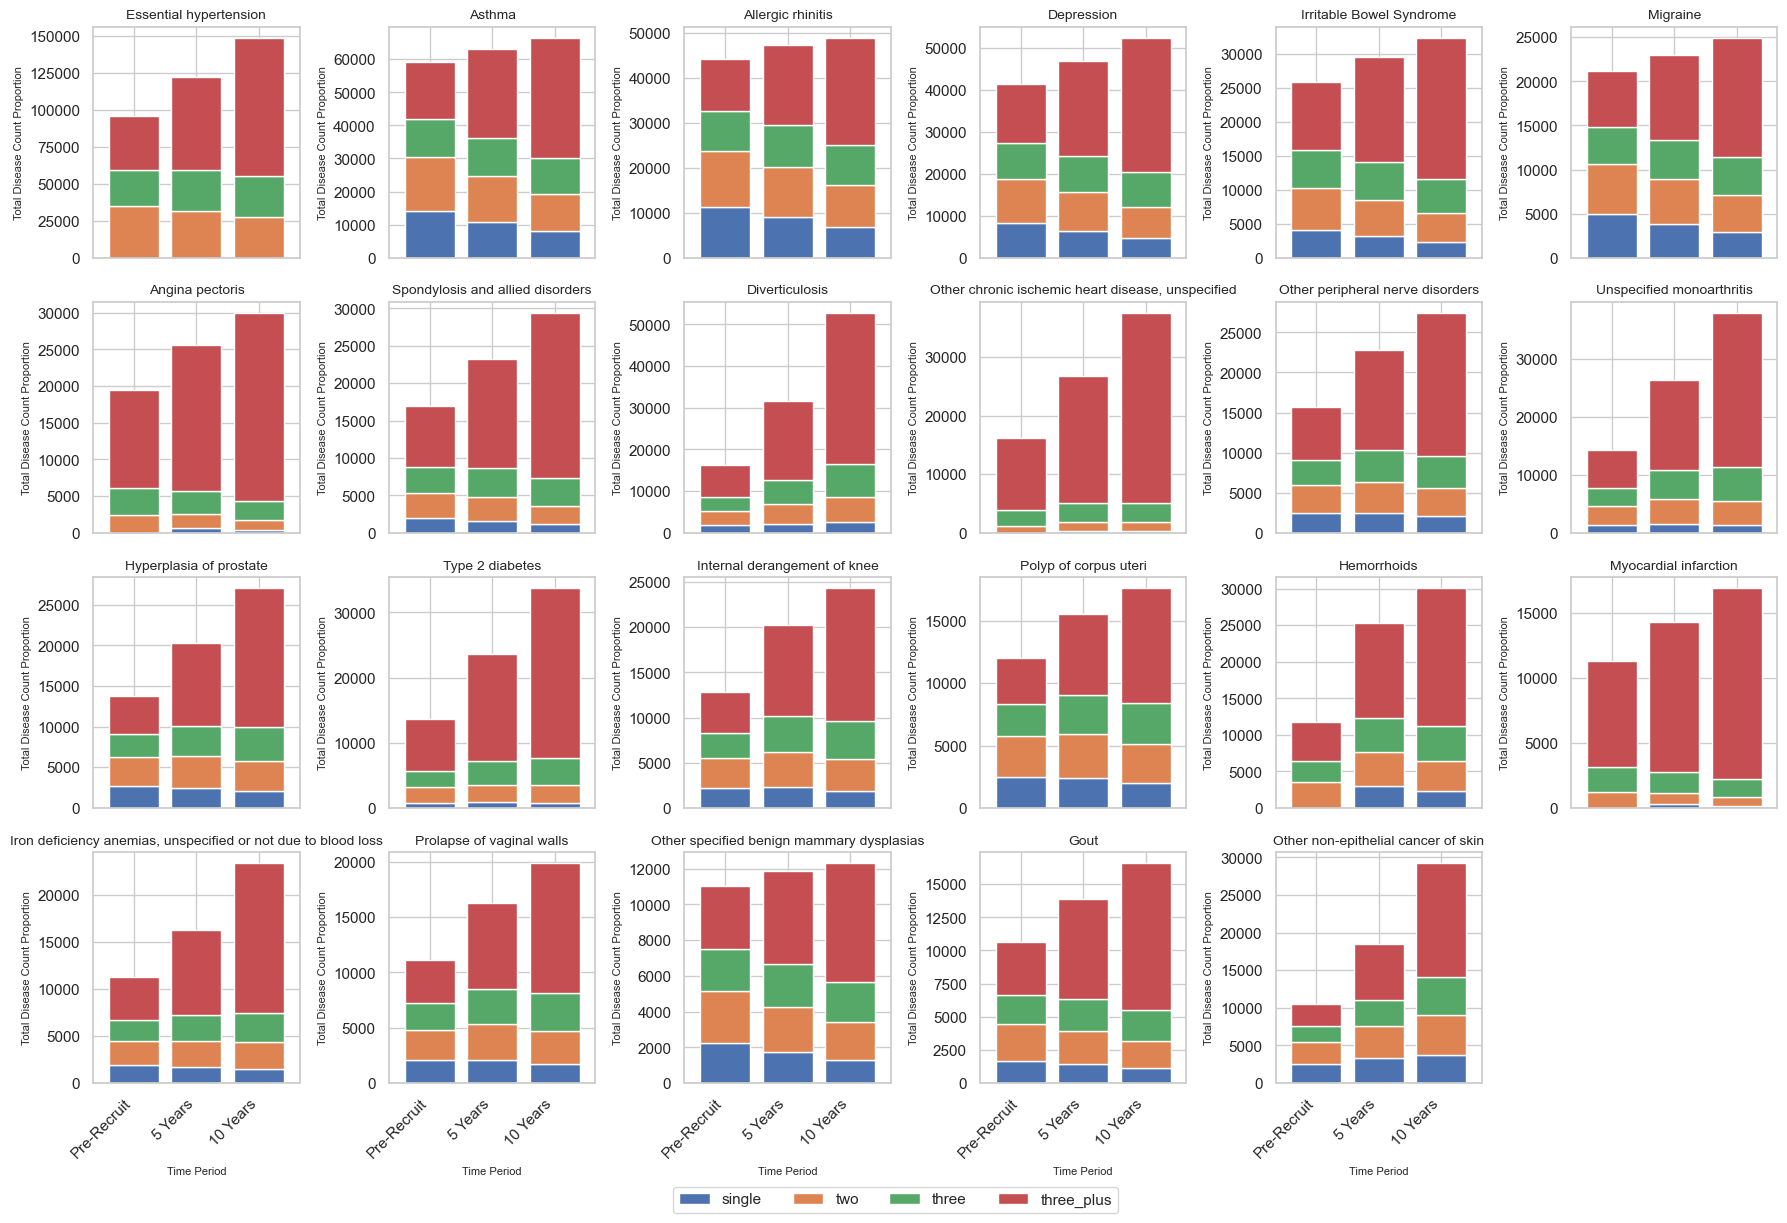

In [491]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the figure size and number of rows/columns for subplots
num_diseases = 23  # Total diseases
ncols = 6  # Number of columns in the subplot grid
nrows = (num_diseases + ncols - 1) // ncols  # Calculate rows based on total number of diseases
condition_order = ['single', 'two', 'three', 'three_plus']
time_order = {'pre_recruit': 0, '5_years': 1, '10_years': 2}

# Create subplots: 23 subplots, each representing one disease
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 3 * nrows),sharex=True)
axes = axes.flatten()  # Flatten to make it easier to index in the loop

# Define colors for the stacked bar segments
#colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

# Plot for each disease
for idx, disease in enumerate(melted_df['disease_name'].unique()):
    # Filter data for the current disease
    disease_data = proportions.loc[proportions['disease_name'] == disease, :]
    disease_data = disease_data.drop(columns=['total_counts'])
    disease_data = disease_data[['disease_name', 'time', 'single', 'two', 'three', 'three_plus']]
    
    # Map time periods to numeric values
    disease_data['time'] = disease_data['time'].apply(lambda x: time_order[x])
    disease_data.sort_values(by=['time'], inplace=True)
    
    if disease_data.empty:
        # If there is no data for this disease, hide the axis
        ax = axes[idx]
        ax.axis('off')
        continue
    
    # Plot the stacked bar chart
    ax = axes[idx]  # Select the appropriate subplot for the current disease
    
    # Plot the data
    disease_data.plot(x='time', kind='bar', stacked=True, ax=ax, width=0.8, legend=False)

    # Set the title and labels for each subplot
    ax.set_title(f'{disease}', fontsize=10)
    ax.set_xlabel('Time Period', fontsize=8)
    ax.set_ylabel('Total Disease Count Proportion', fontsize=8)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Pre-Recruit', '5 Years', '10 Years'], rotation=45, ha='right')

# Adjust layout for neatness
plt.tight_layout()

# Add a global legend for all conditions (single, two, three, three_plus) at the bottom
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.01))

for i in range(num_diseases, len(axes)):
    # Hide any extra empty subplots
    axes[i].set_visible(False)
# Adjust the layout and spacing
plt.subplots_adjust(top=0.95, bottom=0.07)
plt.show()

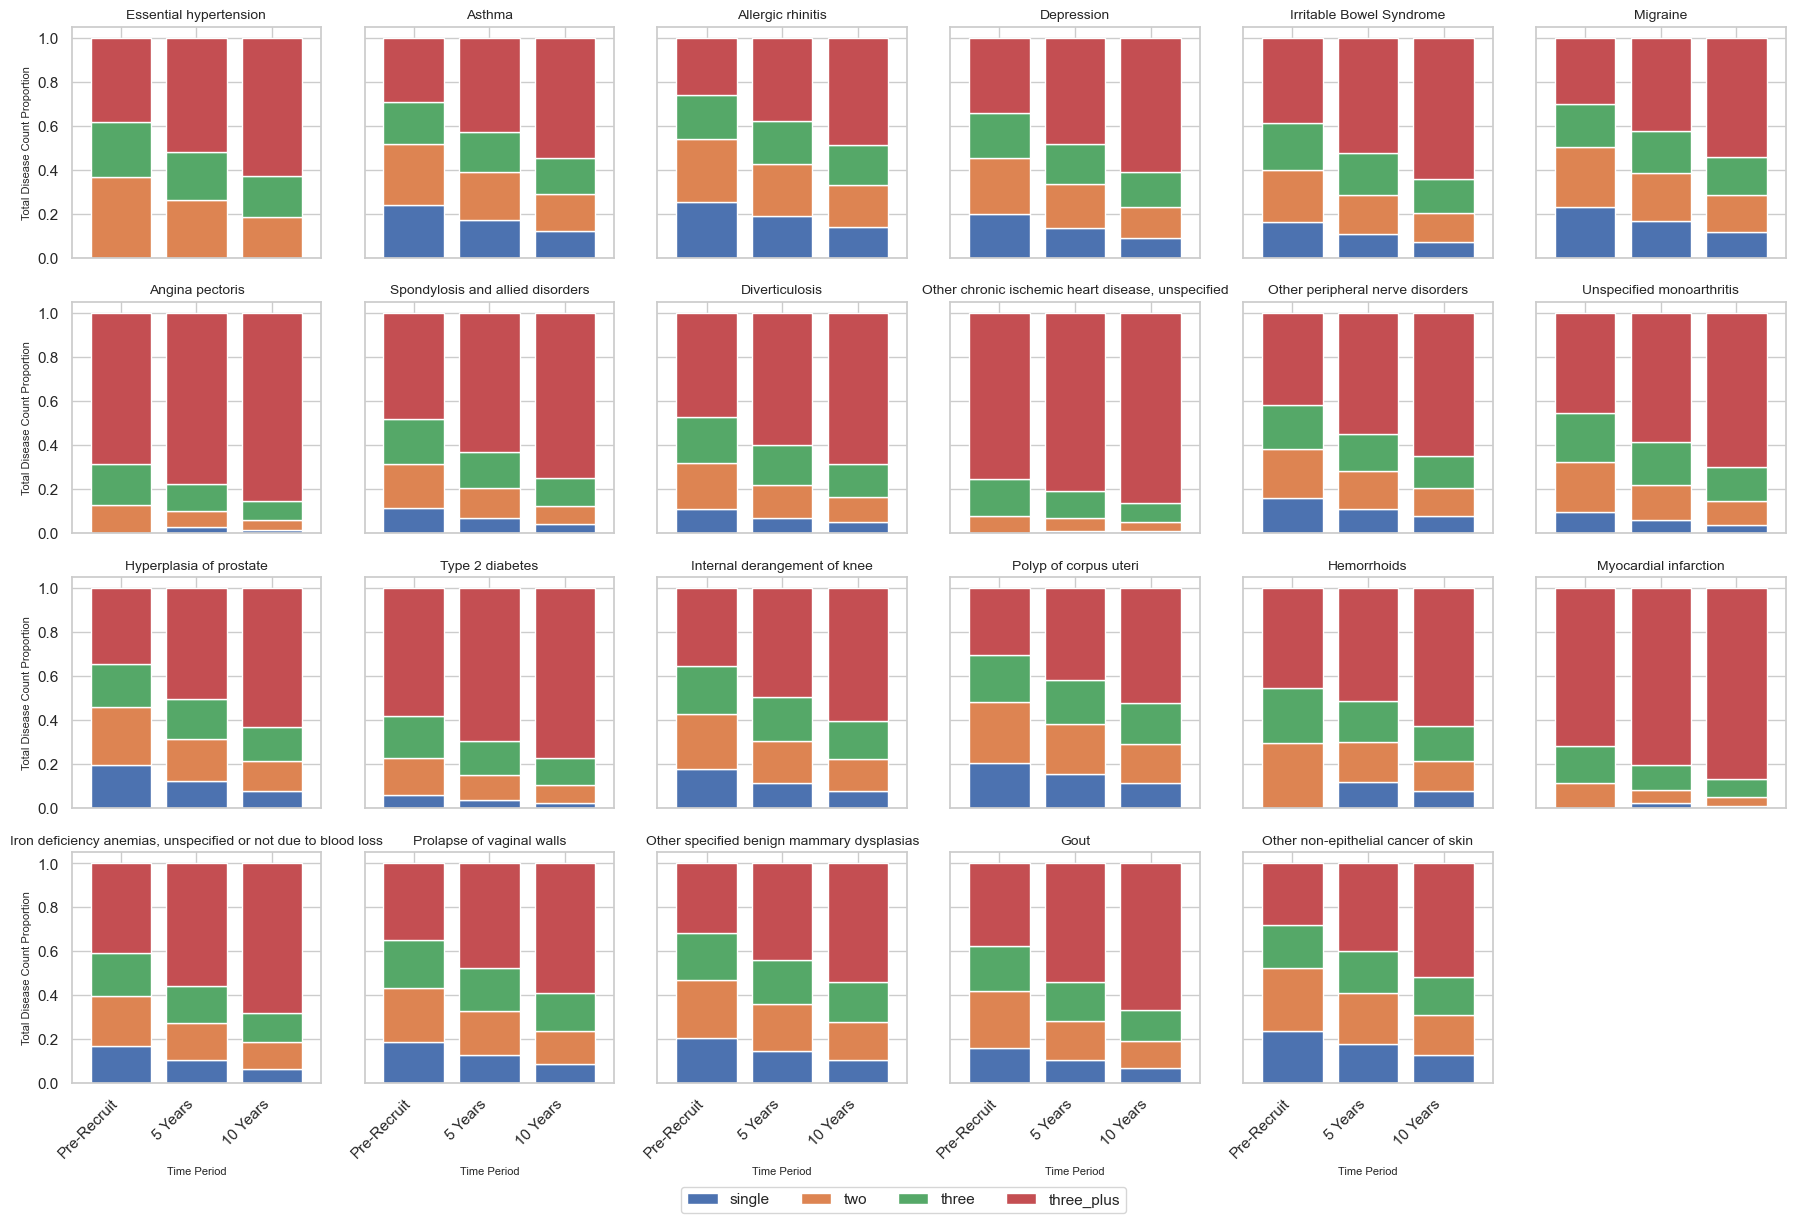

In [501]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the figure size and number of rows/columns for subplots
num_diseases = 23  # Total diseases
ncols = 6  # Number of columns in the subplot grid
nrows = (num_diseases + ncols - 1) // ncols  # Calculate rows based on total number of diseases
condition_order = ['single', 'two', 'three', 'three_plus']
time_order = {'pre_recruit': 0, '5_years': 1, '10_years': 2}

# Create subplots: 23 subplots, each representing one disease
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 3 * nrows),sharex=True,sharey=True)
axes = axes.flatten()  # Flatten to make it easier to index in the loop

# Define colors for the stacked bar segments
#colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

# Plot for each disease
for idx, disease in enumerate(melted_df['disease_name'].unique()):
    # Filter data for the current disease
    disease_data = proportions_y.loc[proportions_y['disease_name'] == disease, :]
    disease_data = disease_data.drop(columns=['total_counts'])
    disease_data = disease_data[['disease_name', 'time', 'single', 'two', 'three', 'three_plus']]
    
    # Map time periods to numeric values
    disease_data['time'] = disease_data['time'].apply(lambda x: time_order[x])
    disease_data.sort_values(by=['time'], inplace=True)
    
    if disease_data.empty:
        # If there is no data for this disease, hide the axis
        ax = axes[idx]
        ax.axis('off')
        continue
    
    # Plot the stacked bar chart
    ax = axes[idx]  # Select the appropriate subplot for the current disease
    
    # Plot the data
    disease_data.plot(x='time', kind='bar', stacked=True, ax=ax, width=0.8, legend=False)

    # Set the title and labels for each subplot
    ax.set_title(f'{disease}', fontsize=10)
    ax.set_xlabel('Time Period', fontsize=8)
    ax.set_ylabel('Total Disease Count Proportion', fontsize=8)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Pre-Recruit', '5 Years', '10 Years'], rotation=45, ha='right')

# Adjust layout for neatness
plt.tight_layout()

# Add a global legend for all conditions (single, two, three, three_plus) at the bottom
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.01))

for i in range(num_diseases, len(axes)):
    # Hide any extra empty subplots
    axes[i].set_visible(False)
# Adjust the layout and spacing
plt.subplots_adjust(top=0.95, bottom=0.07)
plt.show()